## Logistic Regression
This notebook runs the drug repurposing project's first model, logistic regression. Run all 50 assays, first part would be creating the predictive logistic regression for each assay, and save feature coefficients. We'll use the statistic logistic regression model to look at specific uncommon features' p-value/std error

### Predictive models

In [1]:
import random
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

import pymc as pm
import aesara.tensor as T
import arviz as az


In [2]:
xls = pd.ExcelFile('assay_list.xls')

# Now you can list all sheets in the file
xls.sheet_names

# to read just one sheet to dataframe:
df = []
for i in range(len(xls.sheet_names)):
    df1 = xls.parse(i)
    df.append(df1)

len(df)


34

In [3]:
xls2 = pd.ExcelFile('assay_list2.xls')

for i in range(len(xls2.sheet_names)):
    df1 = xls2.parse(i)
    df.append(df1)

len(df)



50

In [4]:
df[1]

Unnamed: 0  tox21-ap1-agonist-p1  \
0              0                     1   
1              1                     0   
2              2                     0   
3              3                     0   
4              4                     0   
...          ...                   ...   
9052        9206                     0   
9053        9207                     0   
9054        9208                     0   
9055        9209                     0   
9056        9210                     0   

                                          SMILES  MaxEStateIndex  \
0                [Br-].CCCCCCCCCCCCCC[n+]1ccccc1        2.287998   
1                 C[C@]12CC[C@H](C[C@H]1O)C2(C)C        9.814236   
2                CCC2=CN(c1ccccc1)C(CCC)C(=C2)CC        2.473380   
3                                   OCC(=O)OCCCC       10.214402   
4                            Nc1ccc(cc1)C(=O)OCC       11.092937   
...                                          ...             ...   
9052  CC/C(=N\OC\C=C\Cl)C1=C(O)CC(CC(C)SCC)CC1=O       12.447525   
9053                            Oc1cc2ccccc2cc1O        9.167281   
9054              CCN(CC)c1ccc(cc1)/N=N/c2ccccc2        4.235067   
9055                   O=C(c1ccc(Cl)cc1)c2ccccc2       11.914512   
9056        c5ccc6c1cc2cccc3ccc4ccc(c1c4c23)c6c5        2.374444   

      MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex       qed    MolWt  \
0           0.000000           2.287998           0.000000  0.377974  356.392   
1          -0.031250           9.814236           0.031250  0.566800  154.253   
2           0.534907           2.473380           0.534907  0.689255  255.405   
3          -0.538472          10.214402           0.426481  0.442392  132.159   
4          -0.307870          11.092937           0.307870  0.532618  165.192   
...              ...                ...                ...       ...      ...   
9052       -0.037469          12.447525           0.037469  0.363123  359.919   
9053       -0.075278           9.167281           0.075278  0.580080  160.172   
9054        0.870666           4.235067           0.870666  0.692852  253.349   
9055        0.020617          11.914512           0.020617  0.701803  216.667   
9056        1.337645           2.374444           1.337645  0.288335  276.338   

      HeavyAtomMolWt  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0            322.120  ...           0             0           0   
1            136.109  ...           0             0           0   
2            230.205  ...           0             0           0   
3            120.063  ...           0             0           0   
4            154.104  ...           0             0           0   
...              ...  ...         ...           ...         ...   
9052         333.711  ...           1             0           0   
9053         152.108  ...           0             0           0   
9054         234.197  ...           0             0           0   
9055         207.595  ...           0             0           0   
9056         264.242  ...           0             0           0   

      fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                     0             0            0            0             0   
1                     0             0            0            0             0   
2                     0             0            0            0             0   
3                     0             0            0            0             0   
4                     0             0            0            0             0   
...                 ...           ...          ...          ...           ...   
9052                  0             0            0            0             0   
9053                  0             0            0            0             0   
9054                  0             0            0            0             0   
9055                  0             0            0            0             0   
9056           

In [5]:
df[0].iloc[:,1].value_counts()

0    8952
1     732
Name: tox21-ahr-p1, dtype: int64

### Run single assay model with L2 penalty

In [9]:
label_encoder = preprocessing.LabelEncoder()
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
one_assay = df[0]
scaler = StandardScaler().fit(one_assay.iloc[:,3:])
X = scaler.transform(one_assay.iloc[:,3:])
y = label_encoder.fit_transform(one_assay.iloc[:,1])
indices = range(9684)
X_train, X_test, y_train, y_test, indice_train, indice_test = train_test_split(X, y, indices, test_size=0.20, shuffle=True)
pd.DataFrame(indice_train).to_csv('train_index.csv', index=False)
print(len(X_train))
print(len(indice_train))

7747
7747


In [10]:
one_assay.to_csv('one_assay.csv', index=False)

In [11]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([7164,  583]))
(array([0, 1]), array([1788,  149]))


In [12]:
logistic_cv_unbalanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight=None).fit(X_train, y_train)
logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight='balanced').fit(X_train, y_train)


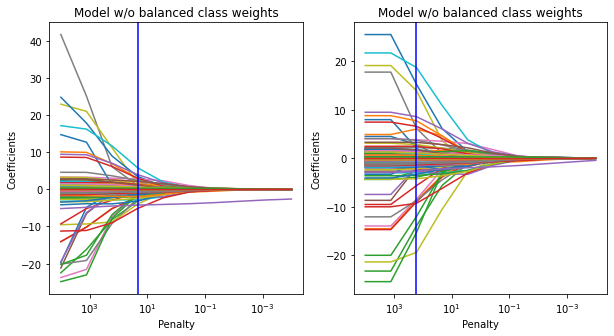

In [13]:
fig, (ax, ax1) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax.plot(logistic_cv_unbalanced.Cs_, logistic_cv_unbalanced.coefs_paths_[1].mean(axis=0))
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.axvline(x =logistic_cv_unbalanced.C_, color = 'b', label = 'axvline - full height')
ax.set_xlabel("Penalty")
ax.set_ylabel("Coefficients")
ax.set_title("Model w/o balanced class weights")

ax1.plot(logistic_cv_balanced.Cs_, logistic_cv_balanced.coefs_paths_[1].mean(axis=0))
ax1.set_xscale("log")
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.axvline(x =logistic_cv_balanced.C_, color = 'b', label = 'axvline - full height')
ax1.set_xlabel("Penalty")
ax1.set_ylabel("Coefficients")
ax1.set_title("Model w/o balanced class weights")


plt.show()

In [14]:
y_pred_unbalanced = logistic_cv_unbalanced.predict(X_test)
y_pred_balanced = logistic_cv_balanced.predict(X_test)

In [15]:
print("Unbalanced model report")
print(classification_report(y_test,y_pred_unbalanced))

Unbalanced model report
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1788
           1       0.69      0.30      0.42       149

    accuracy                           0.94      1937
   macro avg       0.82      0.65      0.69      1937
weighted avg       0.93      0.94      0.92      1937



In [16]:
print("Balanced model report")
print(classification_report(y_test,y_pred_balanced))

Balanced model report
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1788
           1       0.33      0.81      0.47       149

    accuracy                           0.86      1937
   macro avg       0.66      0.84      0.69      1937
weighted avg       0.93      0.86      0.88      1937



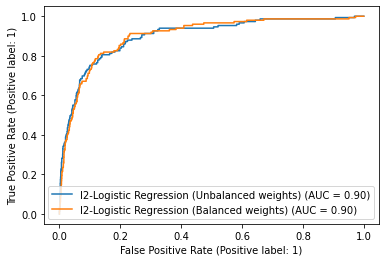

In [17]:
ax = plt.gca()

RocCurveDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
RocCurveDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

plt.show()

In [24]:
from sklearn import metrics
y_pred_prob = logistic_cv_unbalanced.predict_proba(X_test)[:,1]
y_pred_prob_bal = logistic_cv_balanced.predict_proba(X_test)[:,1]

metrics.roc_auc_score(y_test, y_pred_prob)

0.8990980136029908

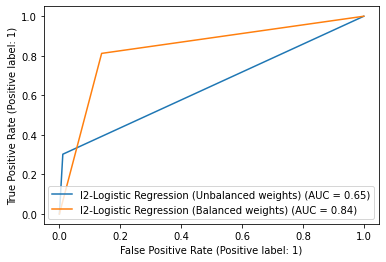

In [18]:
ax = plt.gca()

RocCurveDisplay.from_predictions(y_test, y_pred_unbalanced, ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
RocCurveDisplay.from_predictions(y_test, y_pred_balanced, ax=ax,name="l2-Logistic Regression (Balanced weights)")

plt.show()

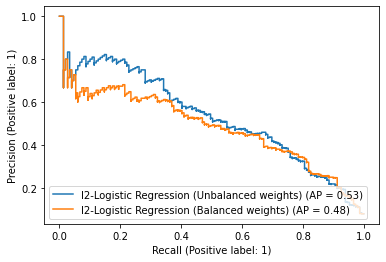

In [19]:
ax = plt.gca()

PrecisionRecallDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
PrecisionRecallDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

plt.show()

In [29]:
print(logistic_cv_unbalanced.Cs_)
# len(logistic_cv_unbalanced.coefs_paths_[1].mean(axis=0))
len(logistic_cv_unbalanced.coef_[0])

[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]


204

### Run all 50 assays

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


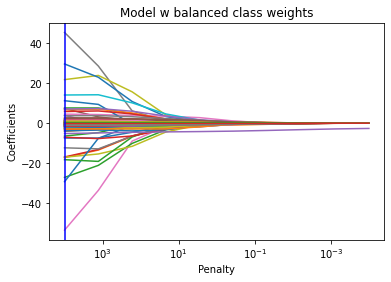

tox21-ahr-p1
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1771
           1       0.64      0.39      0.48       166

    accuracy                           0.93      1937
   macro avg       0.79      0.68      0.72      1937
weighted avg       0.92      0.93      0.92      1937



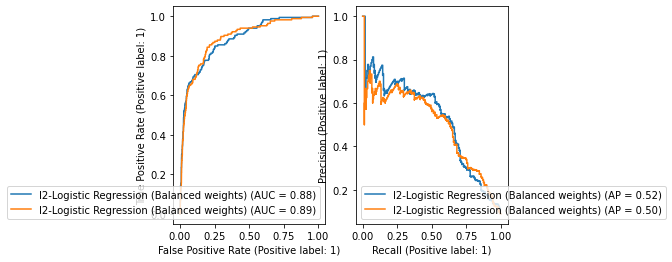

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


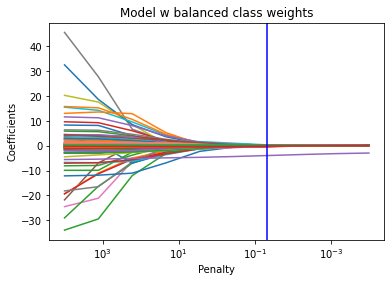

tox21-ap1-agonist-p1
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1721
           1       0.59      0.19      0.28        91

    accuracy                           0.95      1812
   macro avg       0.77      0.59      0.63      1812
weighted avg       0.94      0.95      0.94      1812



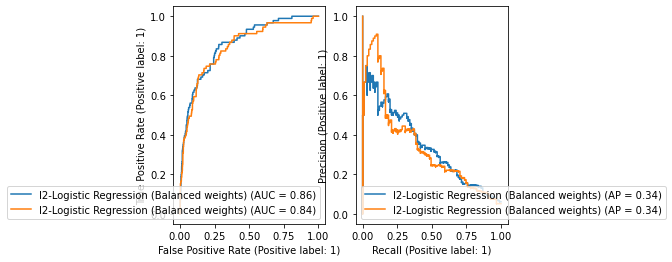

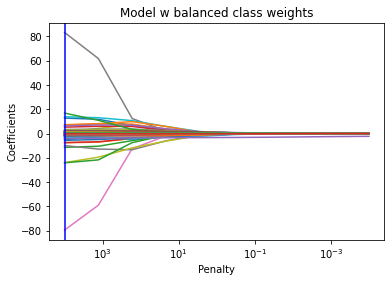

tox21-ar-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1692
           1       0.59      0.23      0.33       204

    accuracy                           0.90      1896
   macro avg       0.75      0.61      0.64      1896
weighted avg       0.88      0.90      0.88      1896



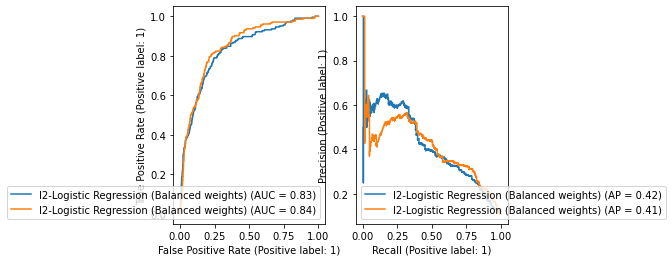

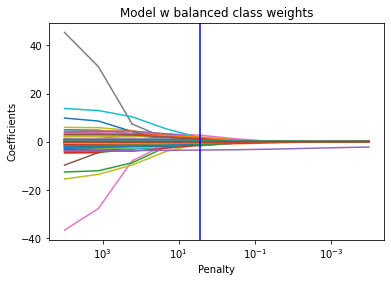

tox21-ar-mda-kb2-luc-agonist-p3
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1598
           1       0.67      0.37      0.48       203

    accuracy                           0.91      1801
   macro avg       0.80      0.67      0.71      1801
weighted avg       0.90      0.91      0.90      1801



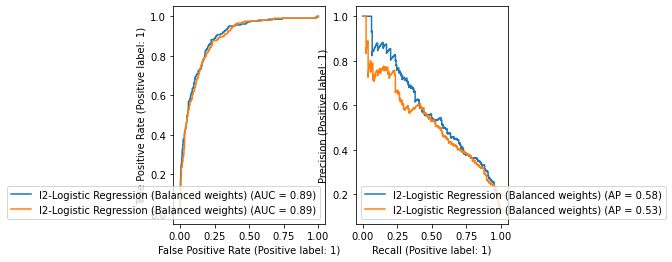

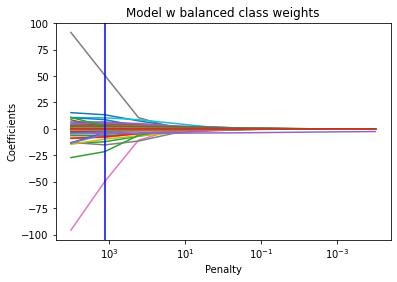

tox21-ar-mda-kb2-luc-antagonist-p1
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1820
           1       0.61      0.32      0.42       161

    accuracy                           0.93      1981
   macro avg       0.78      0.65      0.69      1981
weighted avg       0.92      0.93      0.92      1981



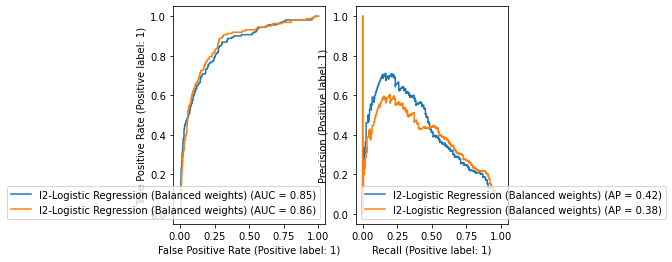

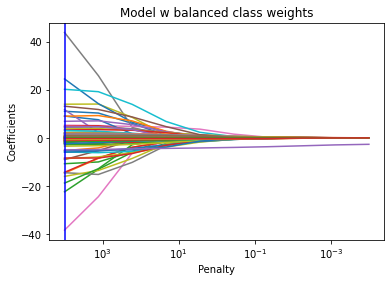

tox21-ar-mda-kb2-luc-antagonist-p2
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1712
           1       0.72      0.35      0.47       140

    accuracy                           0.94      1852
   macro avg       0.83      0.67      0.72      1852
weighted avg       0.93      0.94      0.93      1852



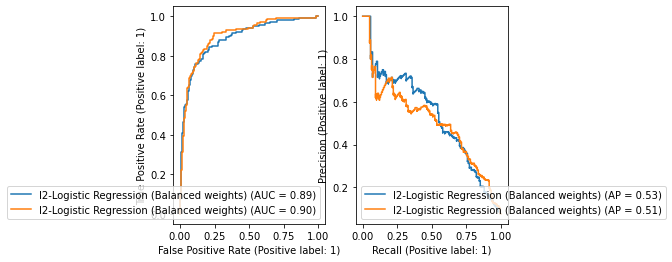

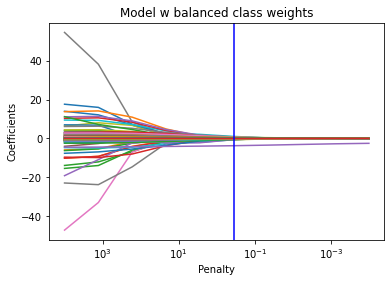

tox21-are-bla-p1
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1594
           1       0.64      0.26      0.37       123

    accuracy                           0.94      1717
   macro avg       0.79      0.62      0.67      1717
weighted avg       0.92      0.94      0.92      1717



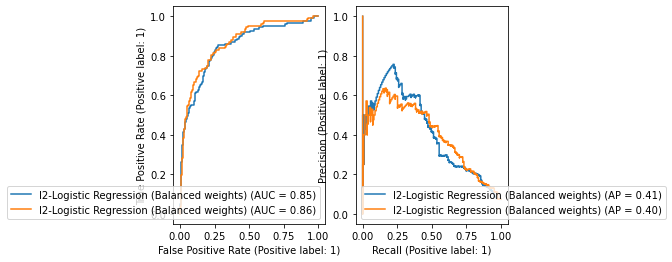

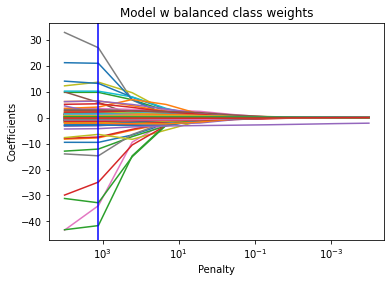

tox21-aromatase-p1
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1678
           1       0.64      0.30      0.41       235

    accuracy                           0.89      1913
   macro avg       0.77      0.64      0.67      1913
weighted avg       0.88      0.89      0.88      1913



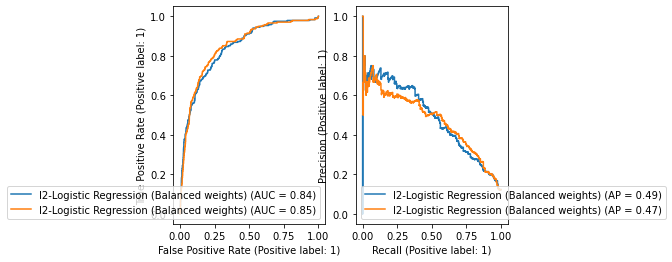

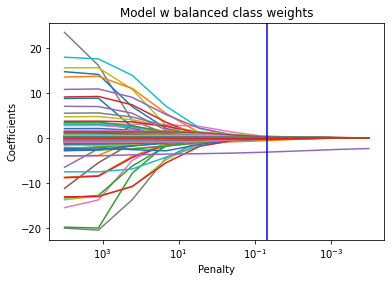

tox21-car-agonist-p1
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1673
           1       0.61      0.29      0.39       139

    accuracy                           0.93      1812
   macro avg       0.77      0.64      0.68      1812
weighted avg       0.92      0.93      0.92      1812



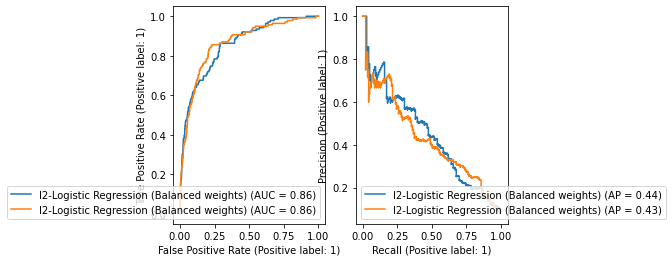

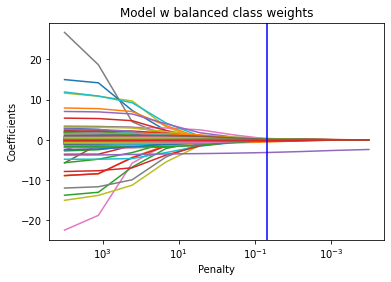

tox21-car-antagonist-p1
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1619
           1       0.66      0.25      0.36       203

    accuracy                           0.90      1822
   macro avg       0.79      0.62      0.66      1822
weighted avg       0.88      0.90      0.88      1822



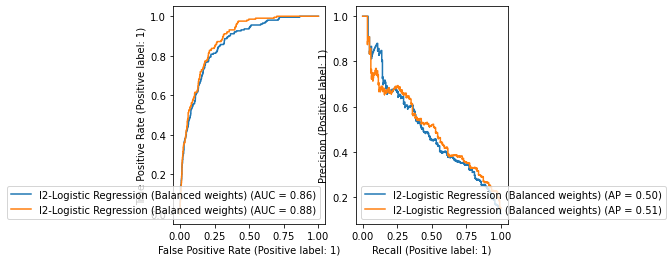

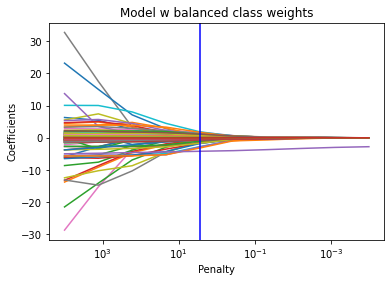

tox21-elg1-luc-agonist-p1
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1811
           1       0.64      0.31      0.42       133

    accuracy                           0.94      1944
   macro avg       0.80      0.65      0.69      1944
weighted avg       0.93      0.94      0.93      1944



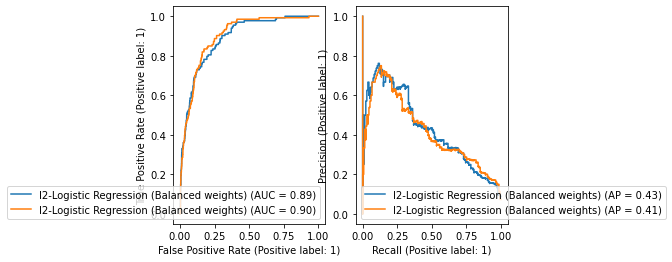

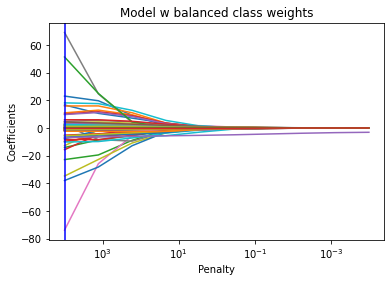

tox21-er-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1819
           1       0.57      0.26      0.36        88

    accuracy                           0.96      1907
   macro avg       0.77      0.63      0.67      1907
weighted avg       0.95      0.96      0.95      1907



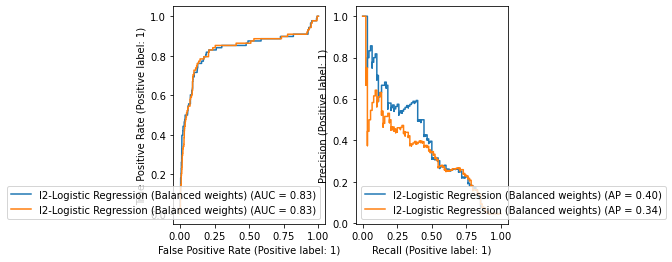

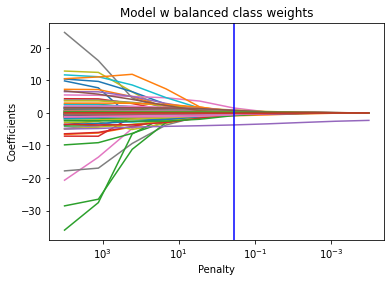

tox21-er-luc-bg1-4e2-agonist-p4
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1591
           1       0.67      0.38      0.48       187

    accuracy                           0.92      1778
   macro avg       0.80      0.68      0.72      1778
weighted avg       0.90      0.92      0.90      1778



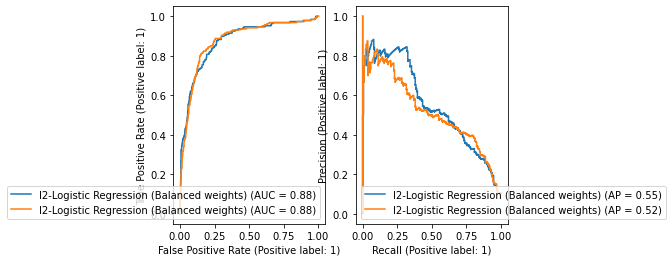

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


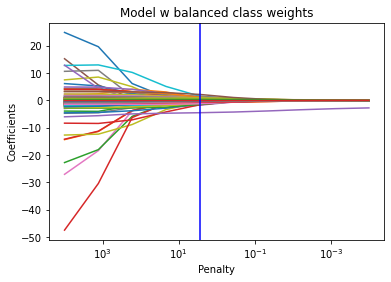

tox21-er-luc-bg1-4e2-antagonist-p1
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1821
           1       0.57      0.29      0.38       119

    accuracy                           0.94      1940
   macro avg       0.76      0.64      0.67      1940
weighted avg       0.93      0.94      0.93      1940



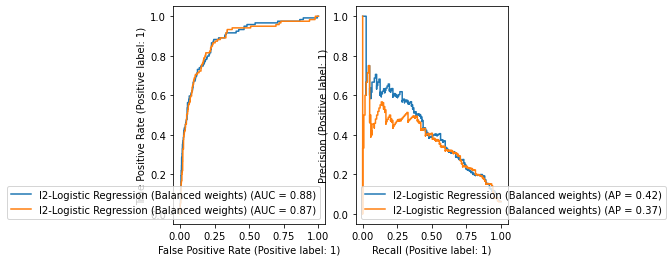

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


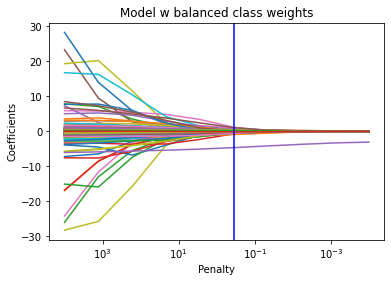

tox21-er-luc-bg1-4e2-antagonist-p2
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1739
           1       0.71      0.31      0.43        97

    accuracy                           0.96      1836
   macro avg       0.84      0.65      0.70      1836
weighted avg       0.95      0.96      0.95      1836



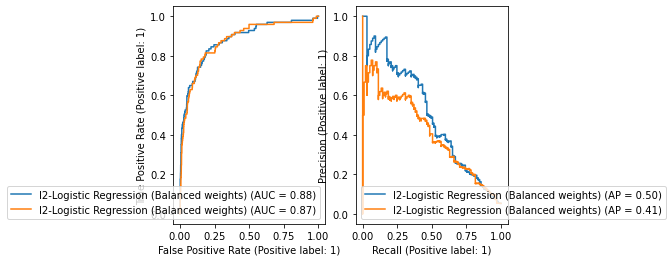

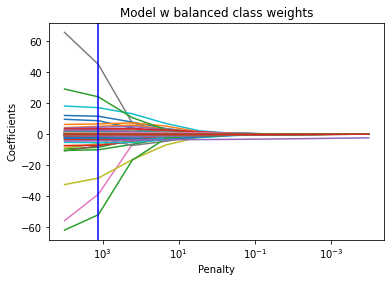

tox21-erb-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1607
           1       0.64      0.33      0.44       178

    accuracy                           0.91      1785
   macro avg       0.79      0.66      0.70      1785
weighted avg       0.90      0.91      0.90      1785



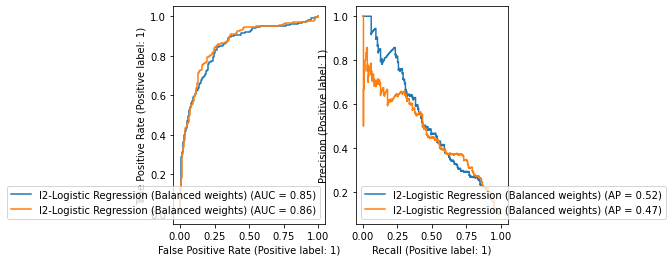

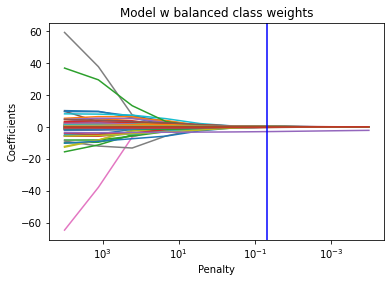

tox21-erb-bla-p1
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1508
           1       0.67      0.36      0.47       182

    accuracy                           0.91      1690
   macro avg       0.80      0.67      0.71      1690
weighted avg       0.90      0.91      0.90      1690



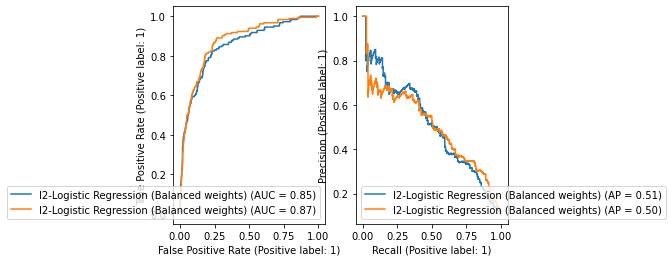

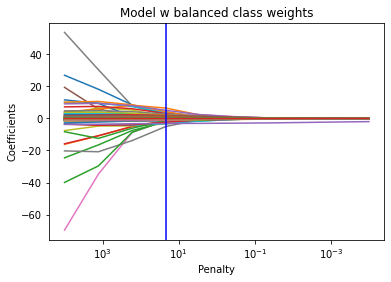

tox21-err-p1
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1511
           1       0.67      0.43      0.52       234

    accuracy                           0.90      1745
   macro avg       0.79      0.70      0.73      1745
weighted avg       0.88      0.90      0.88      1745



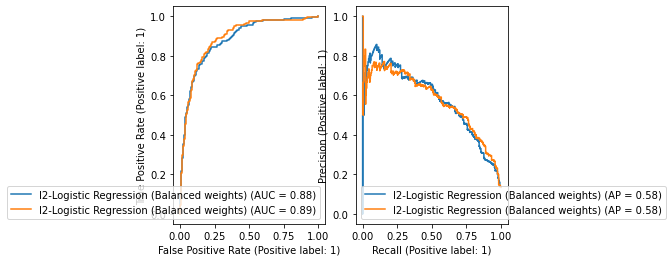

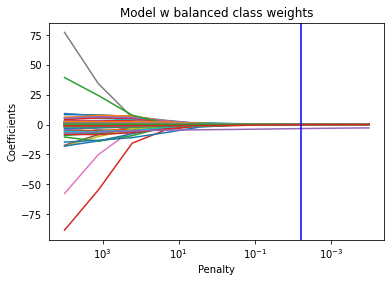

tox21-esre-bla-p1
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1551
           1       0.67      0.14      0.24        98

    accuracy                           0.94      1649
   macro avg       0.81      0.57      0.60      1649
weighted avg       0.93      0.94      0.93      1649



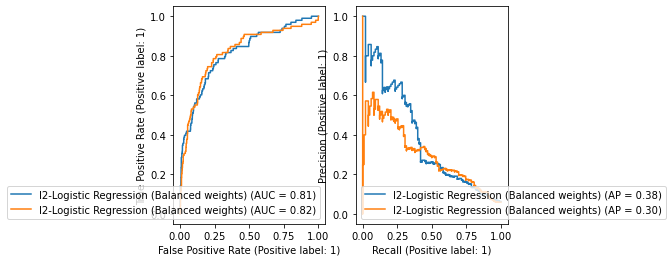

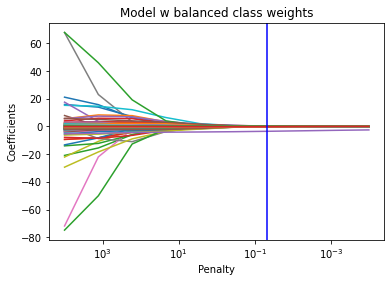

tox21-fxr-bla-agonist-p2
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1412
           1       0.63      0.25      0.36       144

    accuracy                           0.92      1556
   macro avg       0.78      0.62      0.66      1556
weighted avg       0.90      0.92      0.90      1556



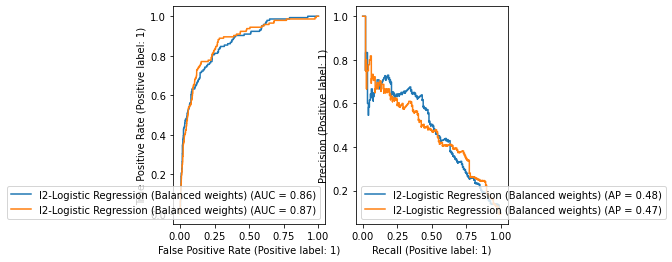

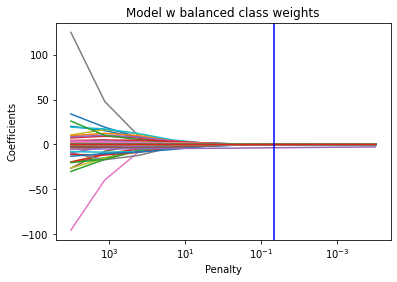

tox21-fxr-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1524
           1       0.65      0.21      0.32       105

    accuracy                           0.94      1629
   macro avg       0.80      0.60      0.64      1629
weighted avg       0.93      0.94      0.93      1629



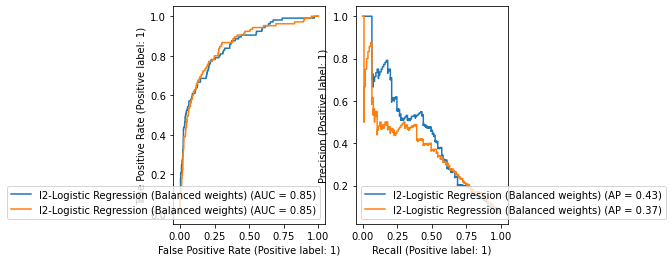

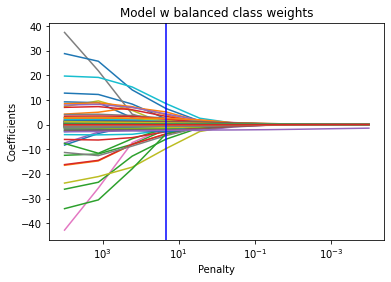

tox21-gh3-tre-antagonist-p1
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1402
           1       0.73      0.52      0.61       325

    accuracy                           0.87      1727
   macro avg       0.81      0.74      0.77      1727
weighted avg       0.86      0.87      0.86      1727



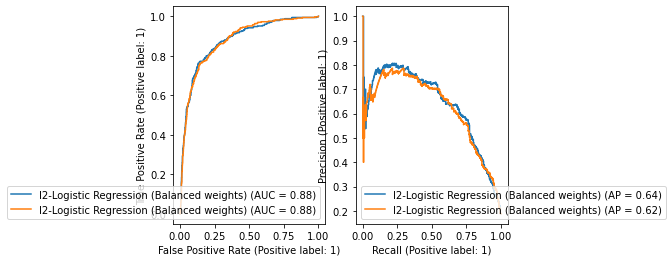

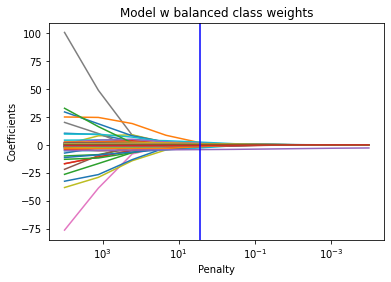

tox21-gr-hela-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1746
           1       0.51      0.26      0.35       118

    accuracy                           0.94      1864
   macro avg       0.73      0.62      0.66      1864
weighted avg       0.92      0.94      0.93      1864



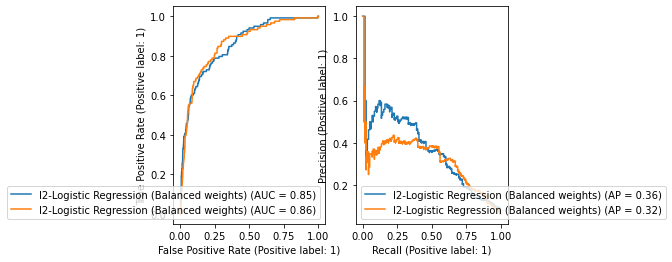

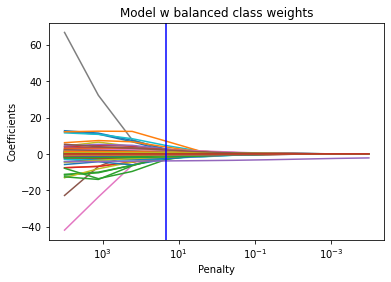

tox21-h2ax-cho-p2
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1562
           1       0.59      0.29      0.39       190

    accuracy                           0.90      1752
   macro avg       0.75      0.63      0.67      1752
weighted avg       0.88      0.90      0.89      1752



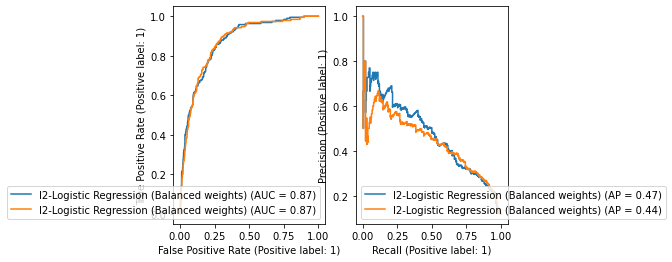

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


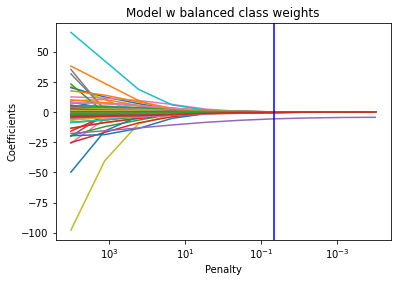

tox21-hdac-p1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1836
           1       0.83      0.14      0.24        36

    accuracy                           0.98      1872
   macro avg       0.91      0.57      0.61      1872
weighted avg       0.98      0.98      0.98      1872



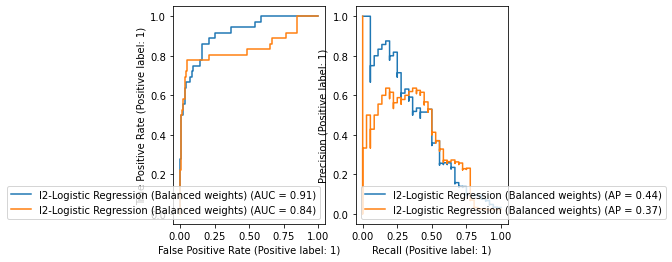

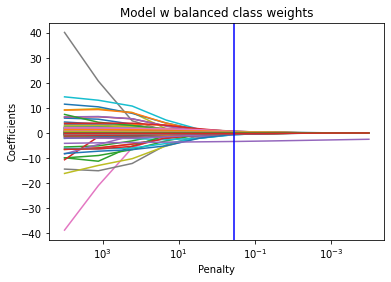

tox21-hre-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1600
           1       0.55      0.22      0.31       153

    accuracy                           0.92      1753
   macro avg       0.74      0.60      0.63      1753
weighted avg       0.90      0.92      0.90      1753



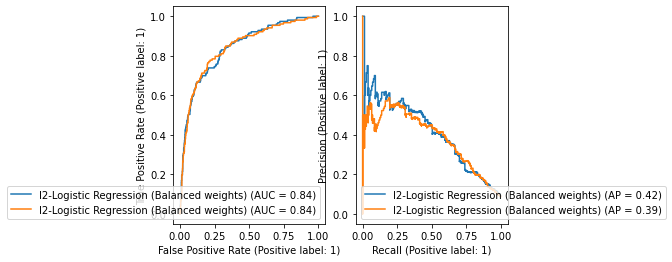

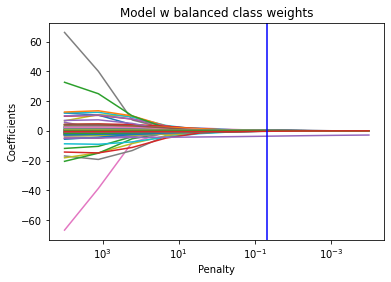

tox21-hse-bla-p1
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1507
           1       0.70      0.15      0.24        95

    accuracy                           0.95      1602
   macro avg       0.82      0.57      0.61      1602
weighted avg       0.93      0.95      0.93      1602



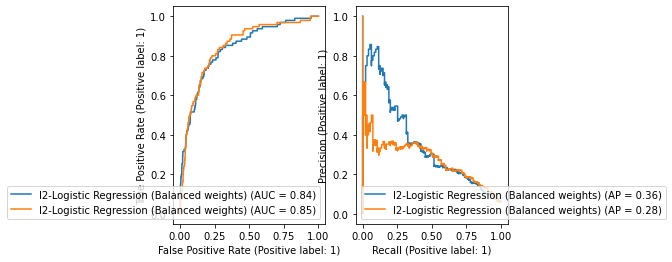

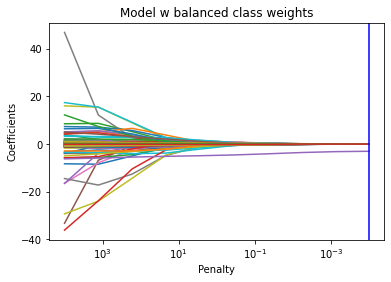

tox21-mitotox-p1
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1863
           1       0.00      0.00      0.00        94

    accuracy                           0.95      1957
   macro avg       0.48      0.50      0.49      1957
weighted avg       0.91      0.95      0.93      1957



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


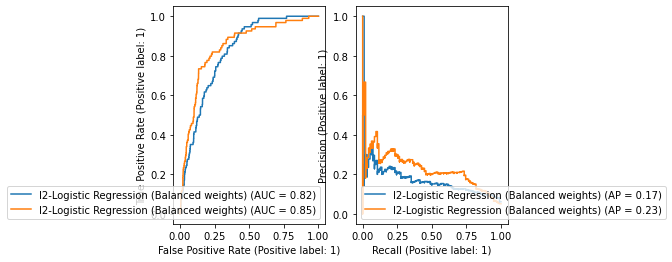

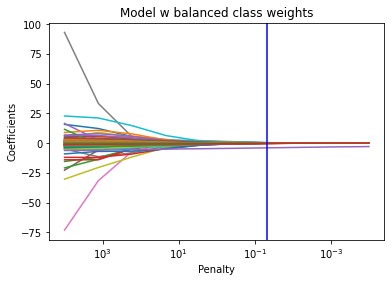

tox21-nfkb-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1538
           1       0.48      0.18      0.26        85

    accuracy                           0.95      1623
   macro avg       0.72      0.58      0.62      1623
weighted avg       0.93      0.95      0.94      1623



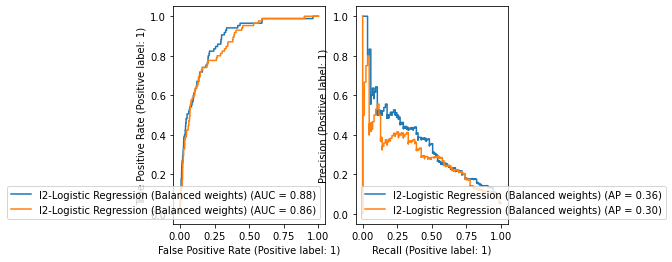

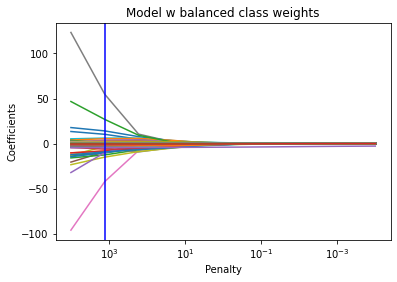

tox21-p53-bla-p1
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1826
           1       0.55      0.26      0.35       137

    accuracy                           0.93      1963
   macro avg       0.75      0.62      0.66      1963
weighted avg       0.92      0.93      0.92      1963



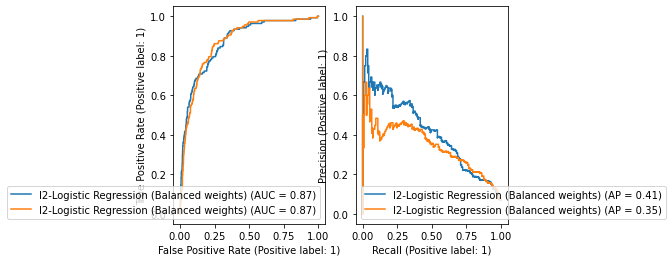

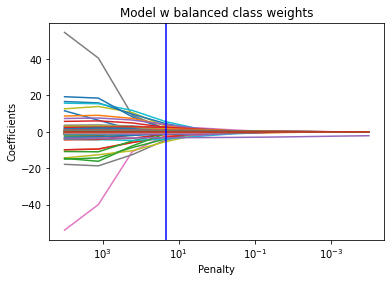

tox21-pgc-err-p1
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1504
           1       0.74      0.43      0.54       247

    accuracy                           0.90      1751
   macro avg       0.82      0.70      0.74      1751
weighted avg       0.89      0.90      0.89      1751



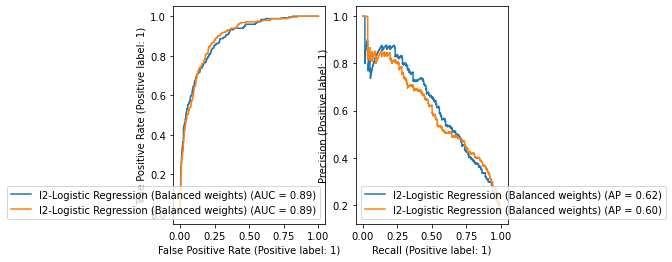

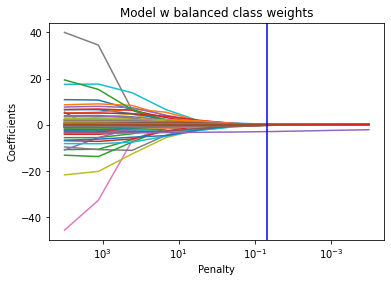

tox21-ppard-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1460
           1       0.73      0.32      0.44       176

    accuracy                           0.91      1636
   macro avg       0.83      0.65      0.70      1636
weighted avg       0.90      0.91      0.90      1636



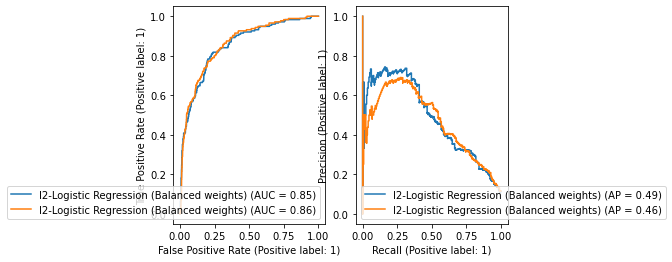

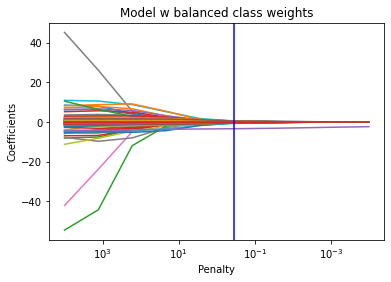

tox21-ppard-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1389
           1       0.64      0.30      0.41       148

    accuracy                           0.92      1537
   macro avg       0.79      0.64      0.68      1537
weighted avg       0.90      0.92      0.90      1537



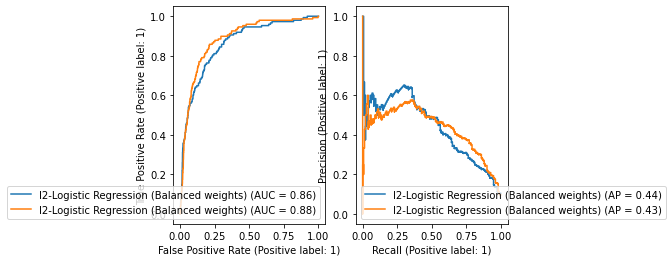

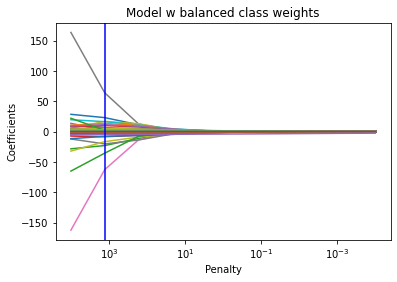

tox21-pparg-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1390
           1       0.55      0.37      0.44       106

    accuracy                           0.93      1496
   macro avg       0.75      0.67      0.70      1496
weighted avg       0.92      0.93      0.93      1496



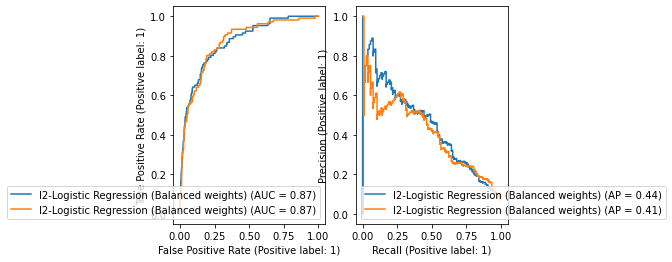

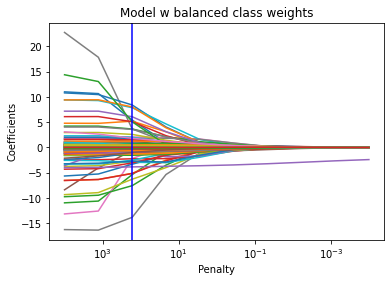

tox21-pr-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1383
           1       0.53      0.32      0.40       129

    accuracy                           0.92      1512
   macro avg       0.74      0.65      0.68      1512
weighted avg       0.90      0.92      0.91      1512



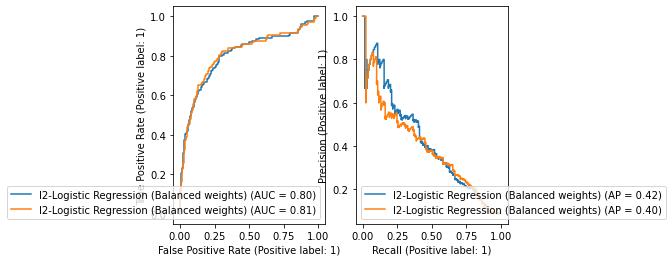

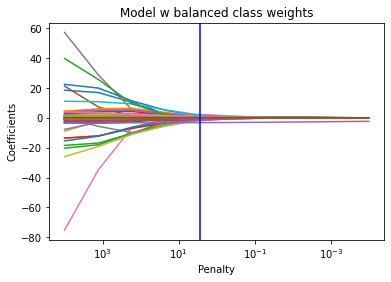

tox21-pr-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1522
           1       0.51      0.26      0.34       152

    accuracy                           0.91      1674
   macro avg       0.72      0.62      0.65      1674
weighted avg       0.89      0.91      0.90      1674



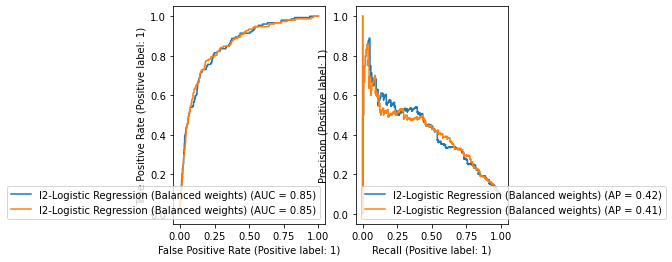

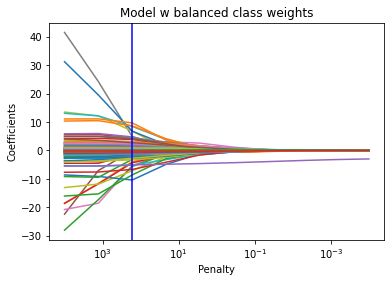

tox21-rar-antagonist-p2
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1739
           1       0.55      0.32      0.40        72

    accuracy                           0.96      1811
   macro avg       0.76      0.65      0.69      1811
weighted avg       0.96      0.96      0.96      1811



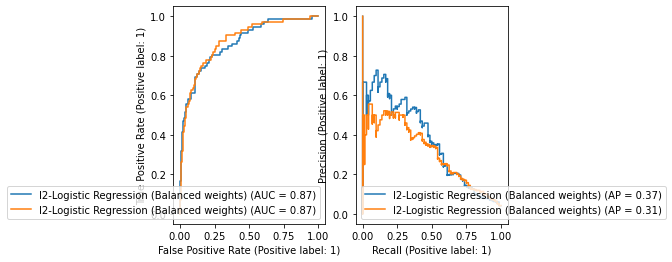

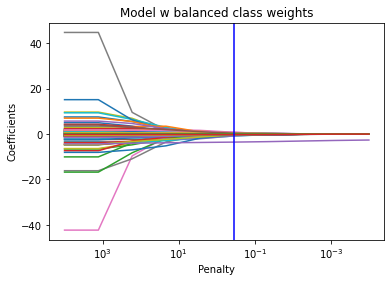

tox21-ror-cho-antagonist-p1
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1579
           1       0.64      0.20      0.31       138

    accuracy                           0.93      1717
   macro avg       0.79      0.60      0.63      1717
weighted avg       0.91      0.93      0.91      1717



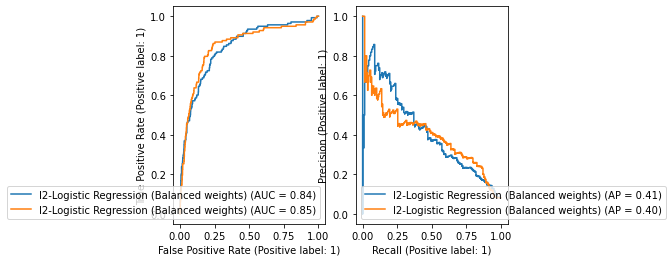

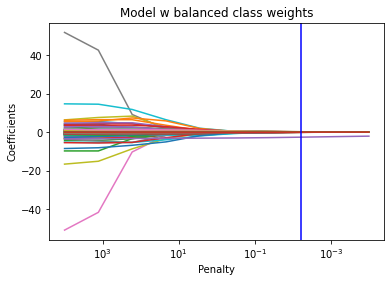

tox21-rxr-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1561
           1       0.63      0.23      0.33       185

    accuracy                           0.90      1746
   macro avg       0.77      0.61      0.64      1746
weighted avg       0.88      0.90      0.88      1746



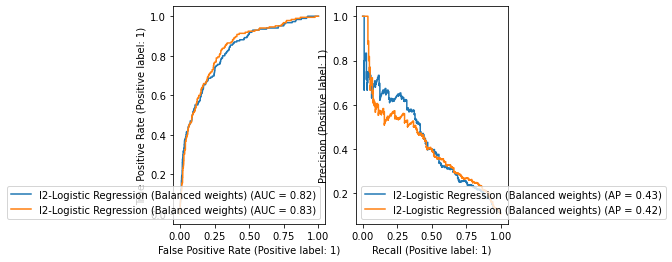

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

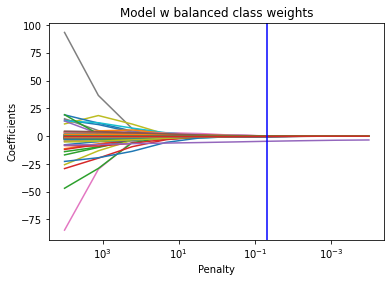

tox21-sbe-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1793
           1       0.62      0.16      0.26        61

    accuracy                           0.97      1854
   macro avg       0.80      0.58      0.62      1854
weighted avg       0.96      0.97      0.96      1854



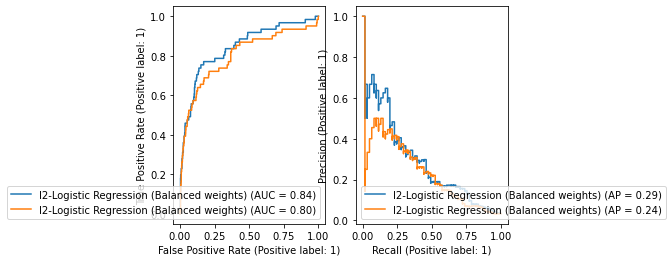

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

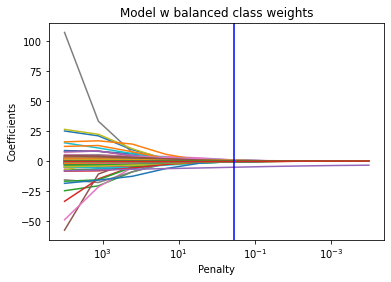

tox21-sbe-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1778
           1       0.72      0.21      0.33        61

    accuracy                           0.97      1839
   macro avg       0.85      0.61      0.66      1839
weighted avg       0.97      0.97      0.96      1839



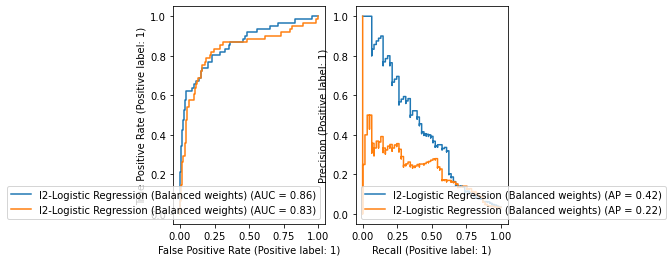

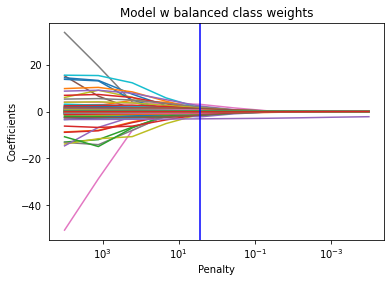

tox21-shh-3t3-gli3-agonist-p1
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1566
           1       0.65      0.36      0.46       207

    accuracy                           0.90      1773
   macro avg       0.79      0.67      0.70      1773
weighted avg       0.89      0.90      0.89      1773



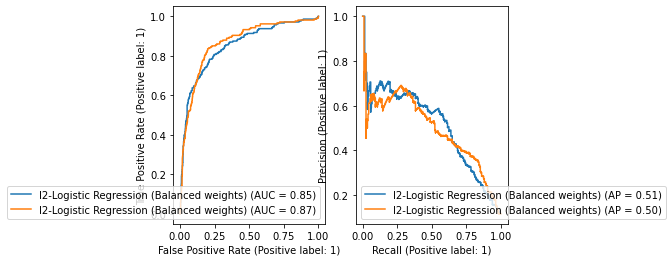

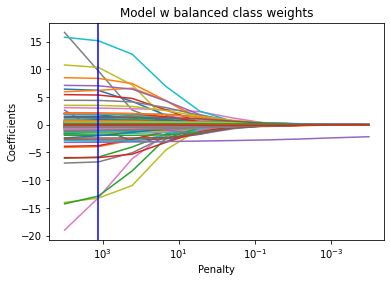

tox21-shh-3t3-gli3-antagonist-p1
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1551
           1       0.68      0.35      0.47       206

    accuracy                           0.90      1757
   macro avg       0.80      0.67      0.71      1757
weighted avg       0.89      0.90      0.89      1757



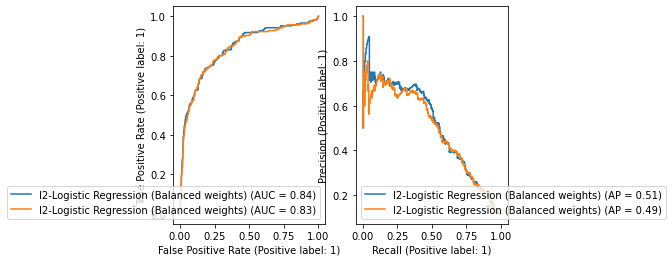

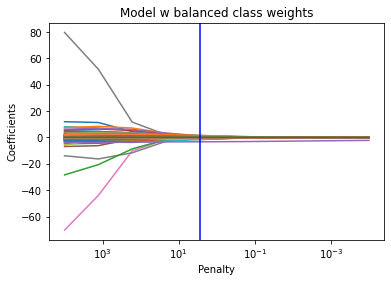

tox21-vdr-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1485
           1       0.70      0.31      0.43       199

    accuracy                           0.90      1684
   macro avg       0.81      0.64      0.69      1684
weighted avg       0.89      0.90      0.89      1684



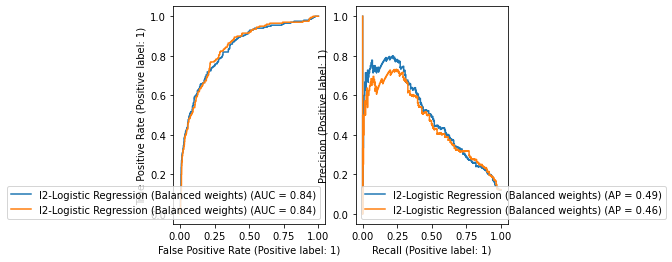

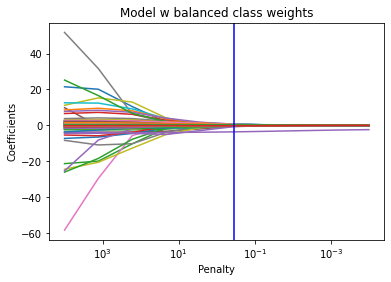

tox21-vdr-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1405
           1       0.59      0.31      0.41       141

    accuracy                           0.92      1546
   macro avg       0.76      0.65      0.68      1546
weighted avg       0.90      0.92      0.91      1546



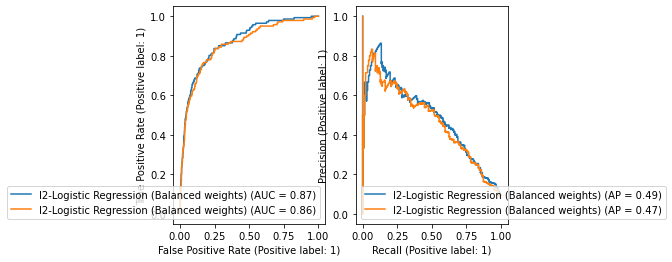

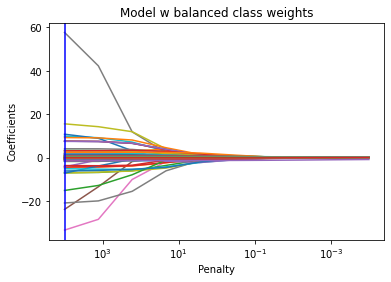

tox21-dt40-p1_653
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1174
           1       0.74      0.61      0.67       573

    accuracy                           0.80      1747
   macro avg       0.78      0.75      0.76      1747
weighted avg       0.80      0.80      0.80      1747



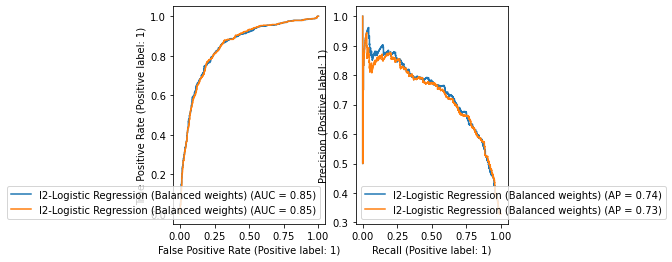

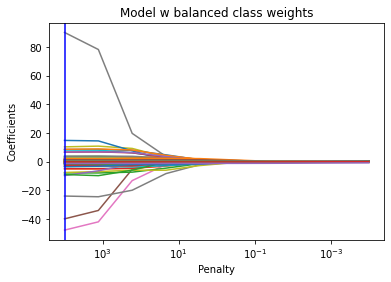

tox21-dt40-p1_100
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1208
           1       0.72      0.61      0.66       596

    accuracy                           0.79      1804
   macro avg       0.77      0.75      0.76      1804
weighted avg       0.79      0.79      0.79      1804



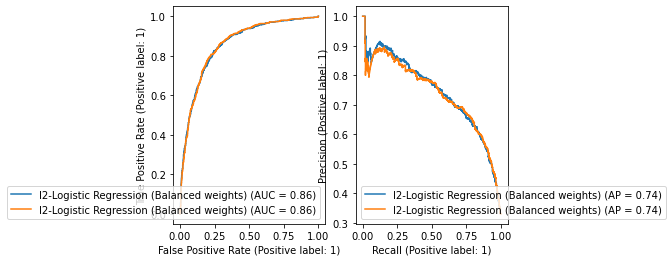

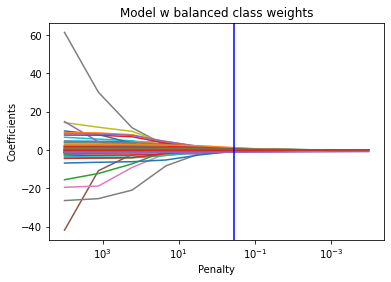

tox21-dt40-p1_657
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1194
           1       0.69      0.59      0.64       545

    accuracy                           0.79      1739
   macro avg       0.76      0.73      0.74      1739
weighted avg       0.78      0.79      0.78      1739



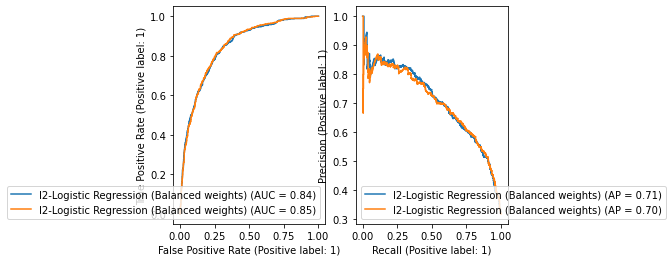

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


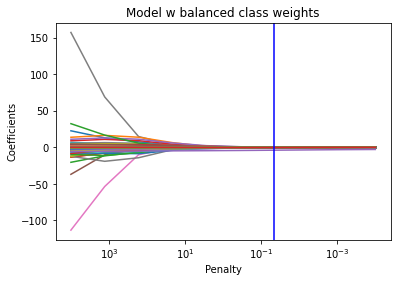

tox21-rt-viability-hepg2-p1
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1744
           1       0.63      0.26      0.37        84

    accuracy                           0.96      1828
   macro avg       0.80      0.63      0.67      1828
weighted avg       0.95      0.96      0.95      1828



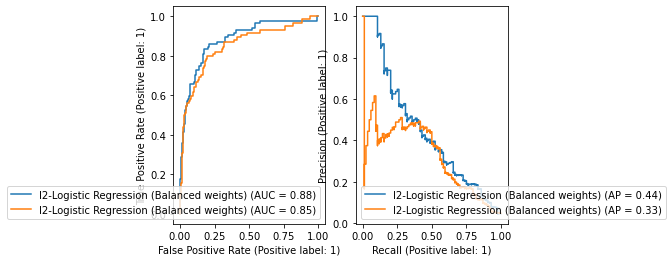

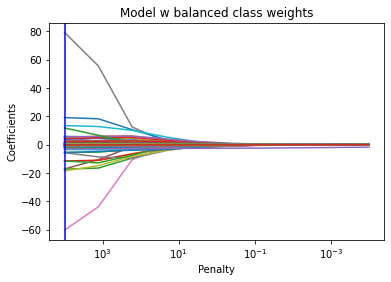

tox21-rt-viability-hek293-p1
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1413
           1       0.69      0.40      0.51       318

    accuracy                           0.86      1731
   macro avg       0.78      0.68      0.71      1731
weighted avg       0.84      0.86      0.84      1731



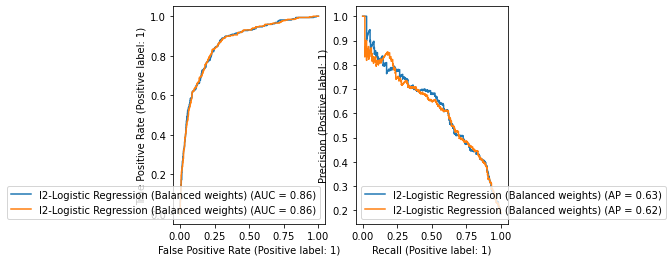

In [26]:
label_encoder = preprocessing.LabelEncoder()
coefs = []
bal_accs = []
bal_accs_w = []
auc_scores = []
auc_scores_w = []
for i in range(len(df)):
    one_assay = df[i]
    scaler = StandardScaler().fit(one_assay.iloc[:,3:])
    X = scaler.transform(one_assay.iloc[:,3:])
    y = label_encoder.fit_transform(one_assay.iloc[:,1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
    logistic_cv_unbalanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight=None).fit(X_train, y_train)
    logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight='balanced').fit(X_train, y_train)

    coef = logistic_cv_balanced.coef_[0]
    coefs.append(coef)
    
    ax = plt.gca()
    fig.set_size_inches(10, 5)

    ax.plot(logistic_cv_unbalanced.Cs_, logistic_cv_unbalanced.coefs_paths_[1].mean(axis=0))
    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    ax.axvline(x =logistic_cv_unbalanced.C_, color = 'b', label = 'axvline - full height')
    ax.set_xlabel("Penalty")
    ax.set_ylabel("Coefficients")
    ax.set_title("Model w balanced class weights")
    plt.show()

    y_pred_unbalanced = logistic_cv_unbalanced.predict(X_test)
    y_pred_balanced = logistic_cv_balanced.predict(X_test)
    
    y_pred_prob = logistic_cv_unbalanced.predict_proba(X_test)[:,1]
    y_pred_prob_bal = logistic_cv_balanced.predict_proba(X_test)[:,1]

    print(one_assay.columns[1])
    print(classification_report(y_test,y_pred_unbalanced))
    
    bal_acc = balanced_accuracy_score(y_test,y_pred_unbalanced)
    bal_accs.append(bal_acc)
    
    bal_acc_w = balanced_accuracy_score(y_test,y_pred_balanced)
    bal_accs_w.append(bal_acc_w)
    
    auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
    auc_scores.append(auc_score)
    
    auc_score_w = metrics.roc_auc_score(y_test, y_pred_prob_bal)
    auc_scores_w.append(auc_score_w)

    fig, (ax, ax1) = plt.subplots(1,2)
#     ax = plt.gca()

    RocCurveDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")
    RocCurveDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

#     ax1 = plt.gca()

    PrecisionRecallDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax1,name="l2-Logistic Regression (Balanced weights)")
    PrecisionRecallDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax1,name="l2-Logistic Regression (Balanced weights)")

    plt.show()


### save all coefficients and change columns and rows name

In [112]:
coefs_df = pd.DataFrame(coefs).T

In [48]:
fea_name = one_assay.iloc[:,3:].columns

In [60]:
assay_name = []
for i in range(len(df)):
    one_assay = df[i]
    y = one_assay.columns[1]
    assay_name.append(y)
len(assay_name)

50

In [113]:
coefs_df.columns = assay_name
coefs_df

tox21-ahr-p1  tox21-ap1-agonist-p1  tox21-ar-bla-antagonist-p1  \
0        0.561438            -29.851188                   -1.228614   
1        0.342046              0.382091                   -0.063352   
2       -0.767200             29.565252                    1.029803   
3        0.130736              0.615974                    0.474781   
4        0.285446             -0.026240                    0.113197   
..            ...                   ...                         ...   
199      0.203540              0.121366                    0.124351   
200     -0.102597             -0.226482                   -0.060948   
201     -0.018181              0.284087                    0.127414   
202     -0.206721             -0.249879                   -0.282458   
203      0.137339              0.381347                    0.278534   

     tox21-ar-mda-kb2-luc-agonist-p3  tox21-ar-mda-kb2-luc-antagonist-p1  \
0                         -12.751230                          -13.914635   
1                           0.293877                            0.311629   
2                          12.262754                           13.466693   
3                           0.232600                            0.209812   
4                           0.007126                            0.095878   
..                               ...                                 ...   
199                        -0.067970                            0.049873   
200                        -0.126755                           -0.150682   
201                         0.018568                            0.044042   
202                        -0.058907                           -0.289155   
203                         0.032729                            0.251073   

     tox21-ar-mda-kb2-luc-antagonist-p2  tox21-are-bla-p1  tox21-aromatase-p1  \
0                            -10.257862        -18.878222            2.282410   
1                              0.123196         -0.390791            0.098404   
2                              9.688670         18.656655           -2.528660   
3                              0.202340          0.472775            0.537541   
4                              0.208011          0.278770            0.068161   
..                                  ...               ...                 ...   
199                            0.008349          0.169253            0.059316   
200                           -0.065887         -0.117276           -0.132707   
201                            0.060792          0.179487            0.102024   
202                           -0.028250          0.344189           -0.133366   
203                            0.224986          0.208538           -0.054876   

     tox21-car-agonist-p1  tox21-car-antagonist-p1  ...  \
0               -8.640458                -2.643101  ...   
1                0.063210                 0.163271  ...   
2                8.268901                 2.229946  ...   
3                0.103775                -0.000675  ...   
4                0.144894                 0.048138  ...   
..                    ...                      ...  ...   
199              0.060624                 0.051019  ...   
200             -0.165160                -0.116743  ...   
201              0.024088                 0.045656  ...   
202             -0.046307                 0.002098  ...   
203              0.035777                 0.081586  ...   

     tox21-sbe-bla-antagonist-p1  tox21-shh-3t3-gli3-agonist-p1  \
0                     -38.163891                      -7.129111   
1                      -0.322426                       0.056666   
2                      37.817584                       6.912139   
3                       0.931060                       0.366258   
4                      -0.082923                       0.050119   
..                           ...                            ...   
199                     0.157071                       0.037262   
200                  

In [128]:
coefs_df.set_axis(fea_name, axis=0)
coefs_df.columns

Index(['tox21-ahr-p1', 'tox21-ap1-agonist-p1', 'tox21-ar-bla-antagonist-p1',
       'tox21-ar-mda-kb2-luc-agonist-p3', 'tox21-ar-mda-kb2-luc-antagonist-p1',
       'tox21-ar-mda-kb2-luc-antagonist-p2', 'tox21-are-bla-p1',
       'tox21-aromatase-p1', 'tox21-car-agonist-p1', 'tox21-car-antagonist-p1',
       'tox21-elg1-luc-agonist-p1', 'tox21-er-bla-antagonist-p1',
       'tox21-er-luc-bg1-4e2-agonist-p4', 'tox21-er-luc-bg1-4e2-antagonist-p1',
       'tox21-er-luc-bg1-4e2-antagonist-p2', 'tox21-erb-bla-antagonist-p1',
       'tox21-erb-bla-p1', 'tox21-err-p1', 'tox21-esre-bla-p1',
       'tox21-fxr-bla-agonist-p2', 'tox21-fxr-bla-antagonist-p1',
       'tox21-gh3-tre-antagonist-p1', 'tox21-gr-hela-bla-antagonist-p1',
       'tox21-h2ax-cho-p2', 'tox21-hdac-p1', 'tox21-hre-bla-agonist-p1',
       'tox21-hse-bla-p1', 'tox21-mitotox-p1', 'tox21-nfkb-bla-agonist-p1',
       'tox21-p53-bla-p1', 'tox21-pgc-err-p1', 'tox21-ppard-bla-agonist-p1',
       'tox21-ppard-bla-antagonist-p1', 'tox21-

/var/folders/mw/vsqjplld57v73jz2c0hw5x00llg6y6/T/ipykernel_64490/1491100679.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


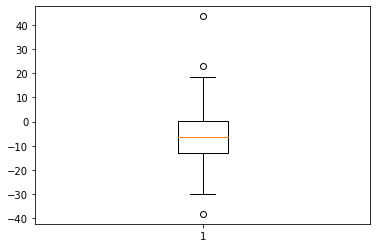

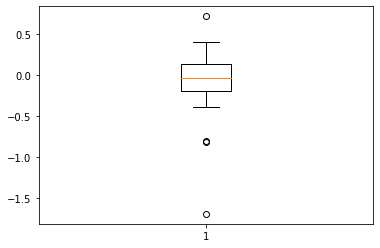

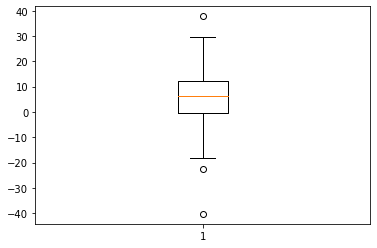

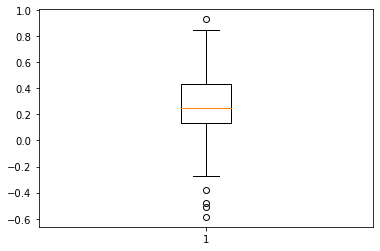

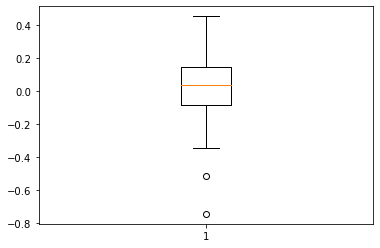

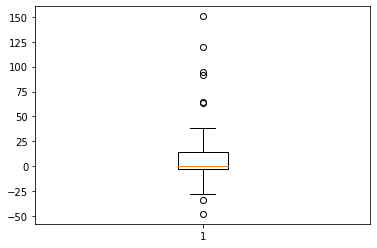

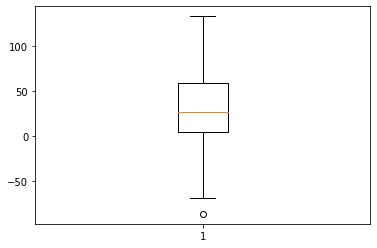

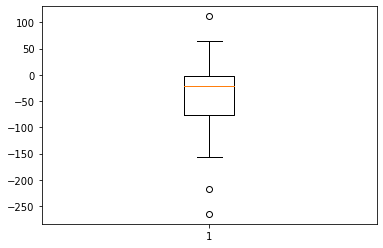

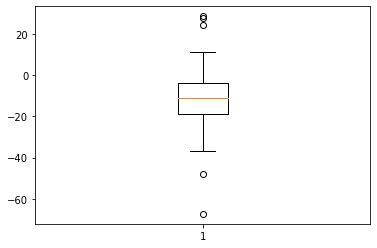

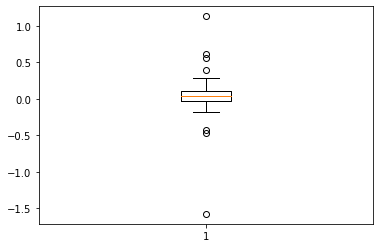

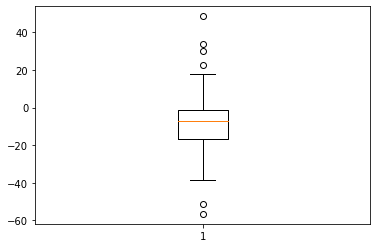

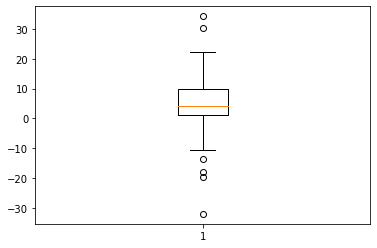

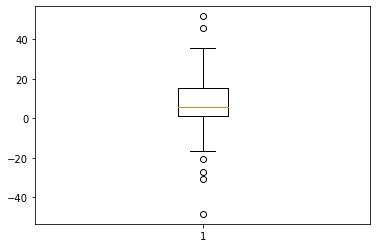

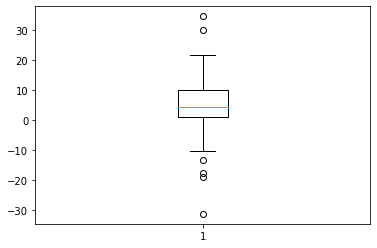

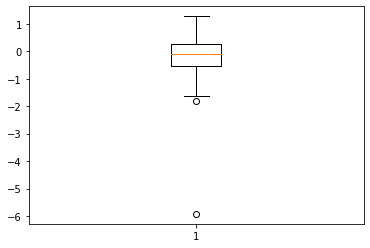

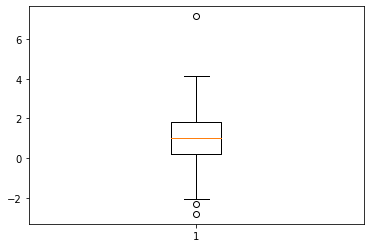

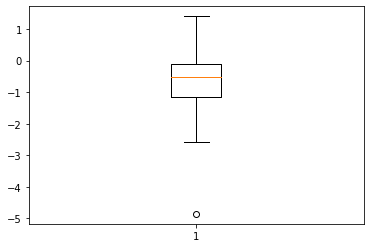

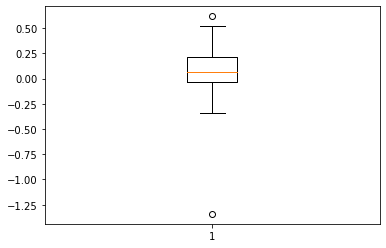

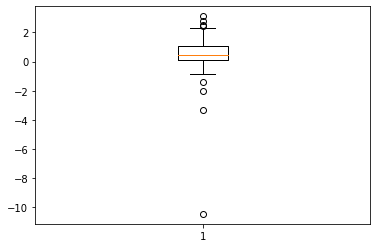

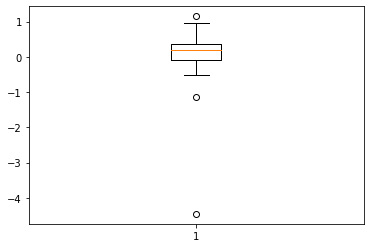

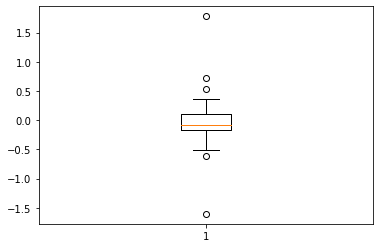

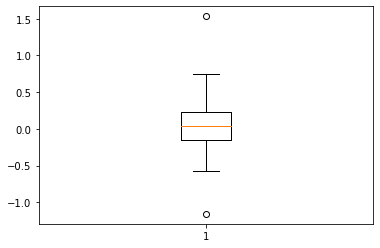

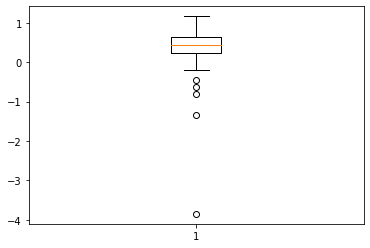

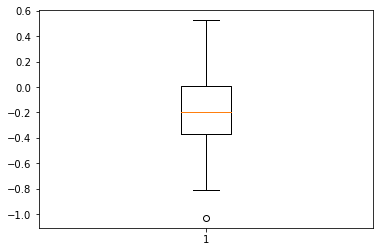

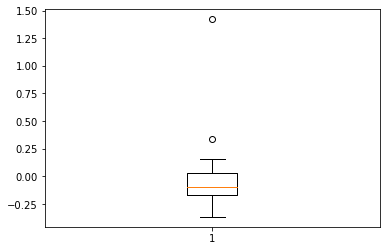

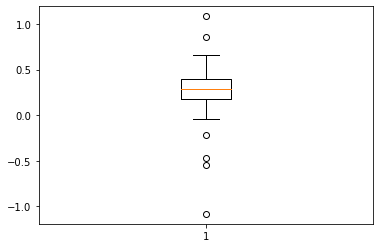

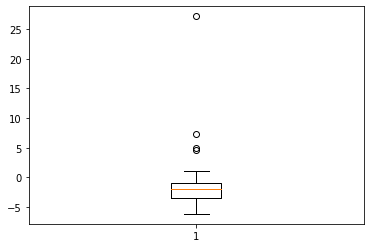

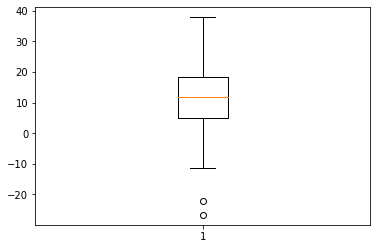

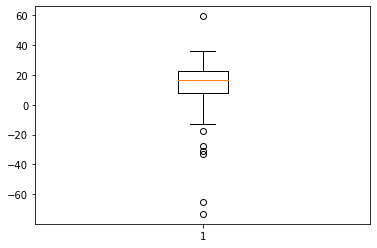

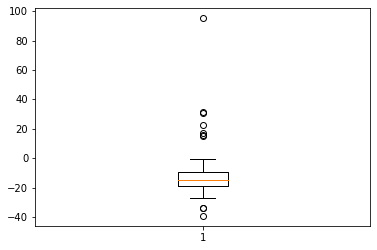

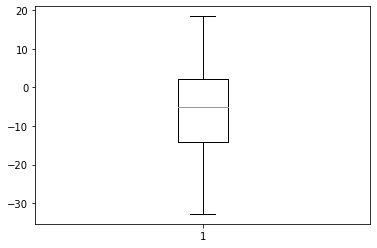

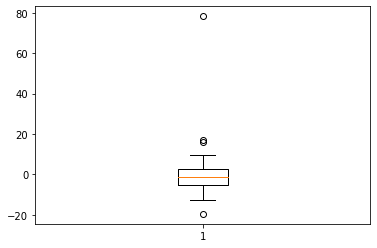

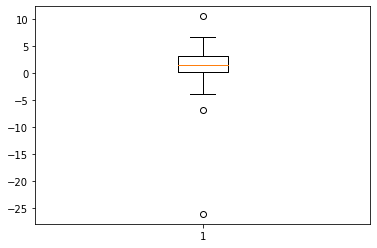

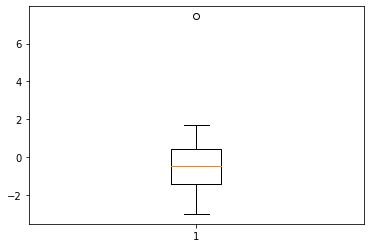

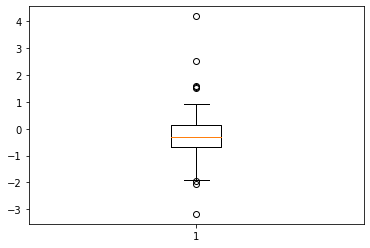

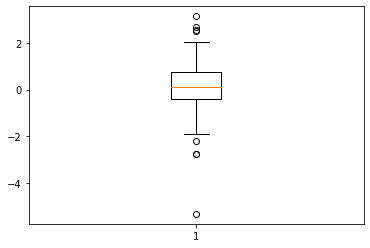

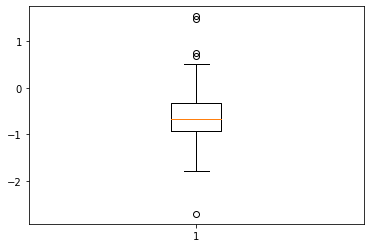

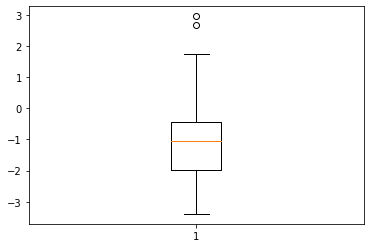

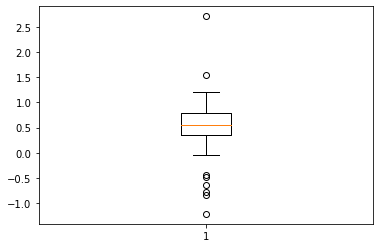

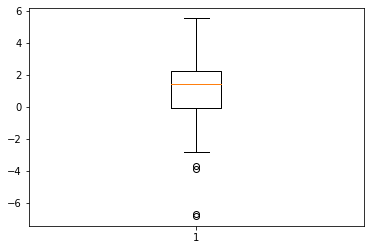

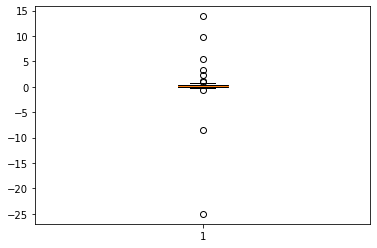

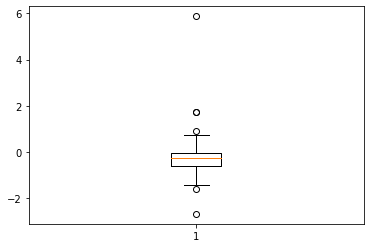

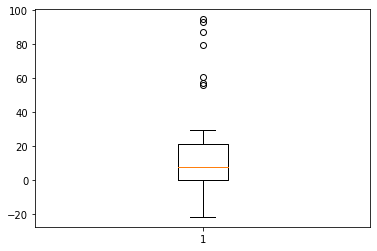

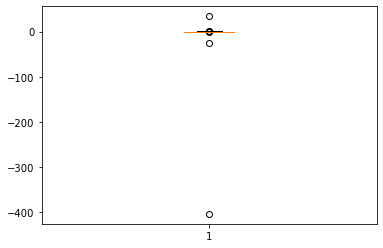

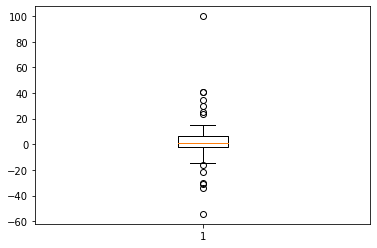

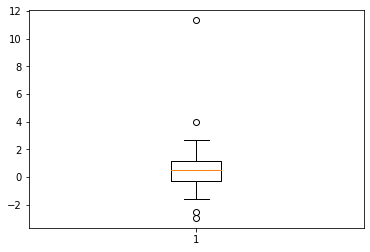

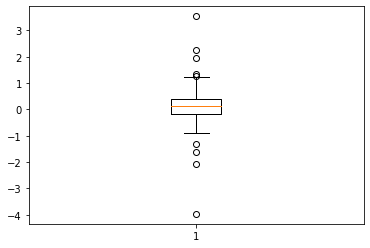

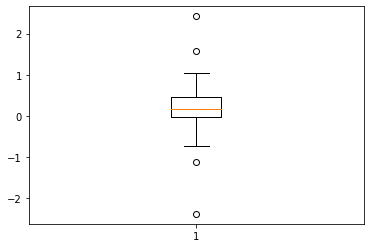

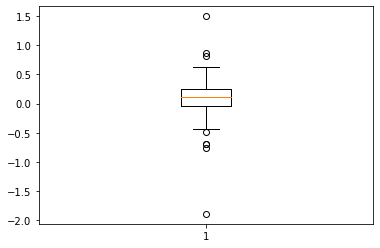

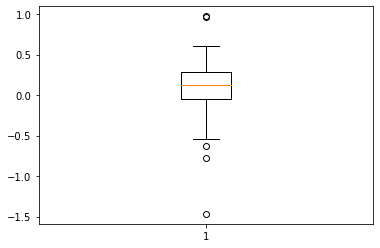

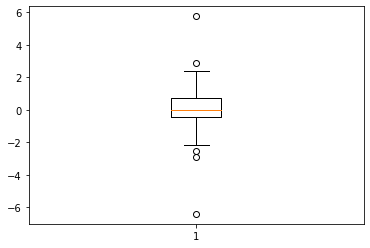

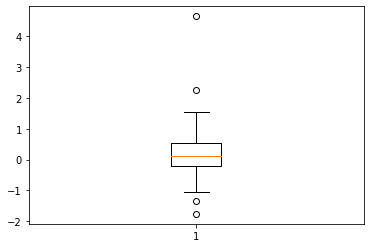

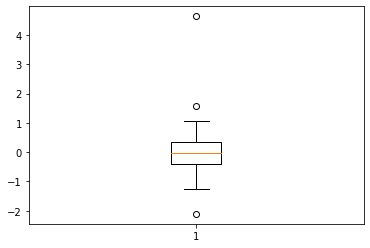

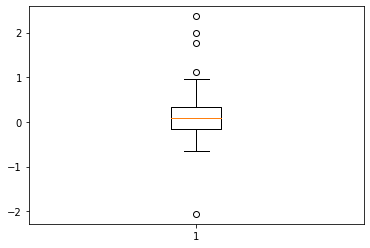

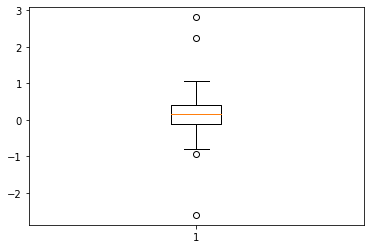

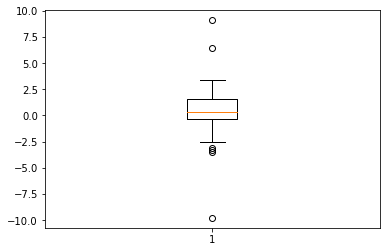

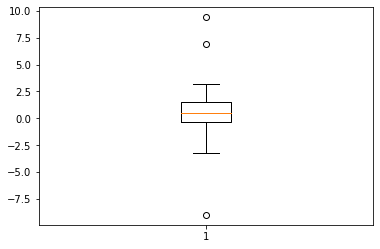

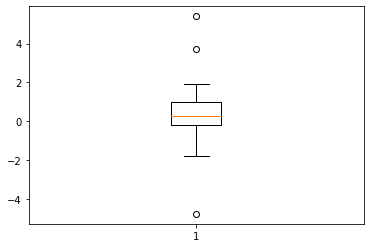

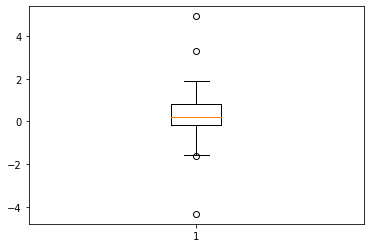

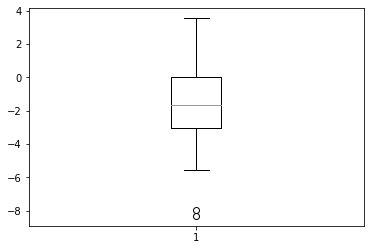

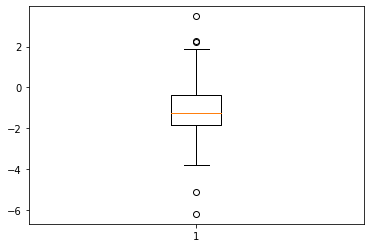

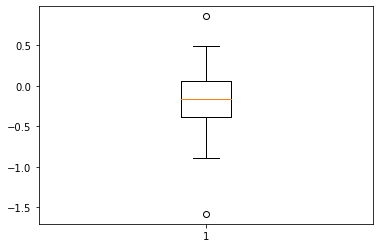

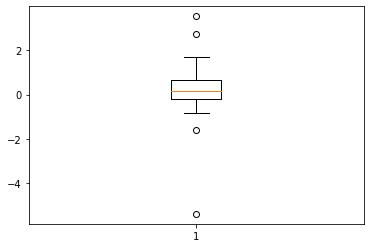

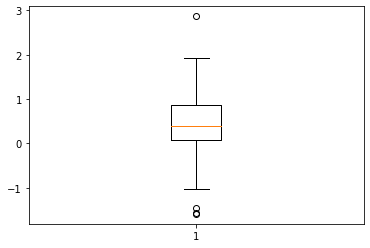

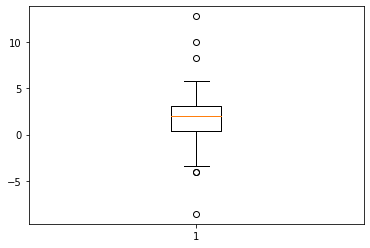

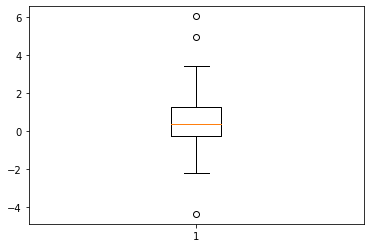

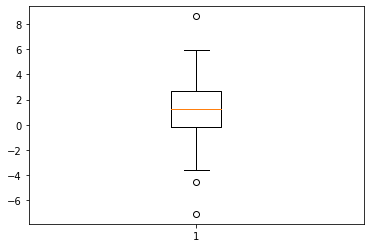

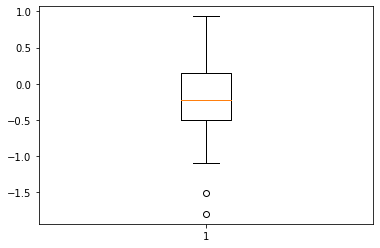

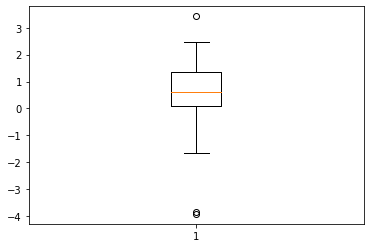

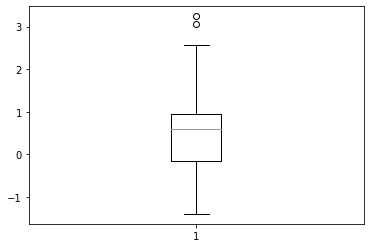

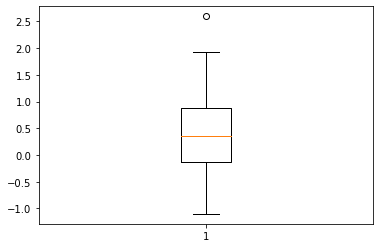

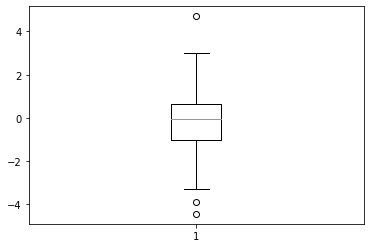

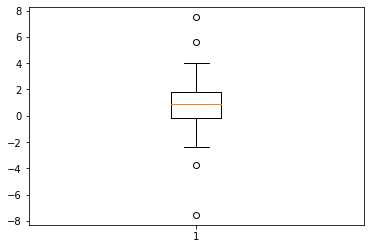

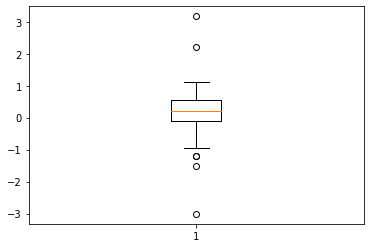

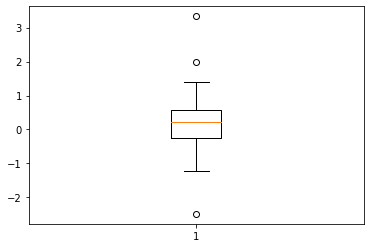

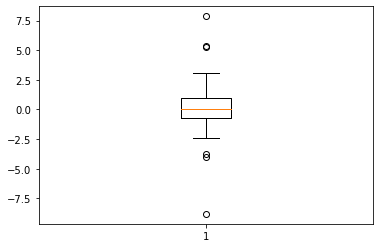

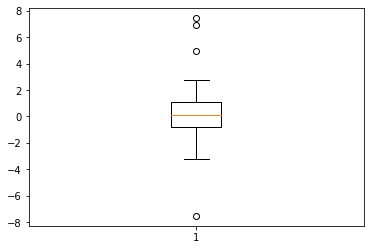

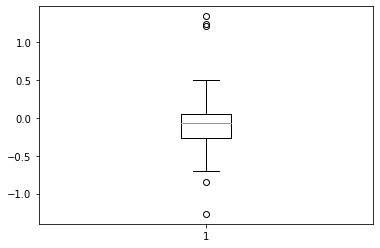

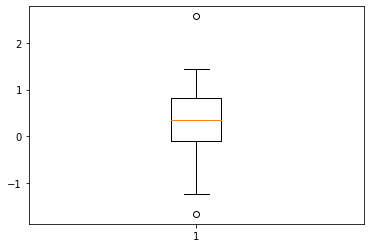

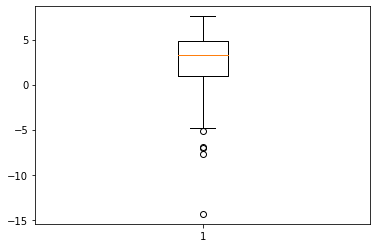

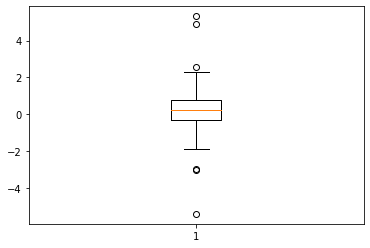

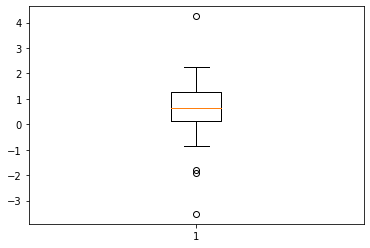

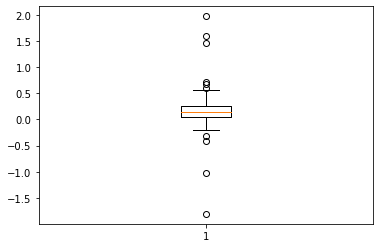

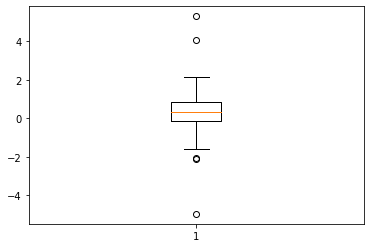

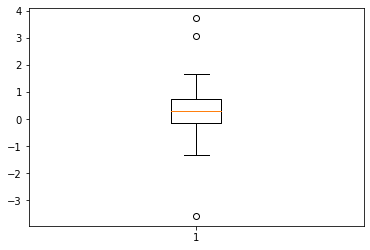

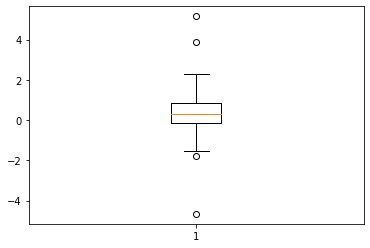

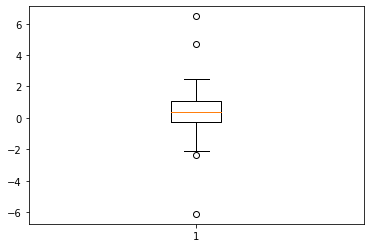

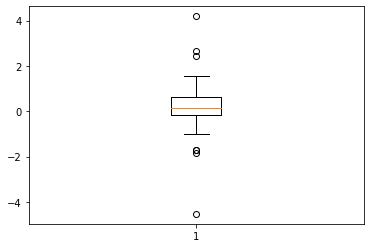

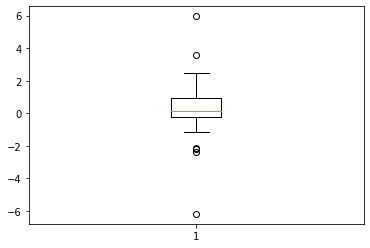

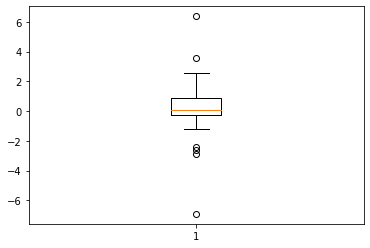

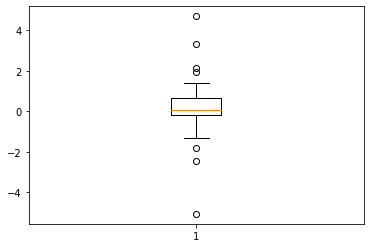

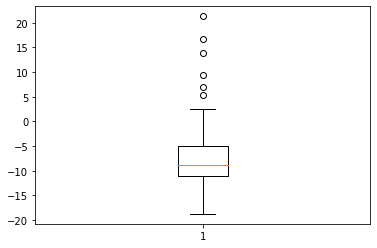

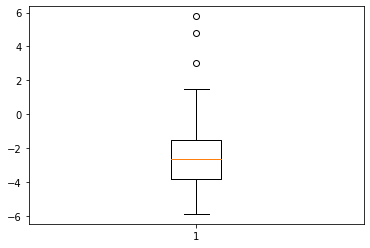

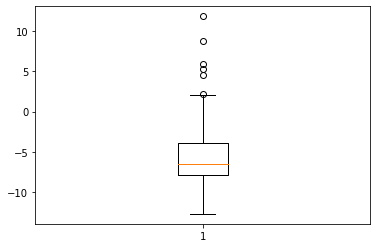

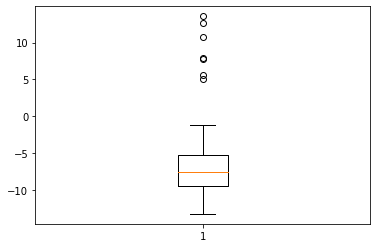

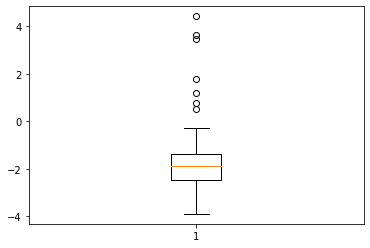

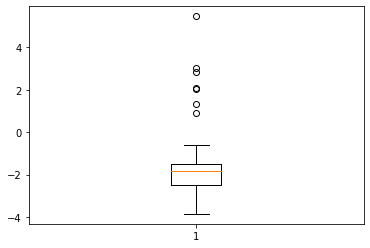

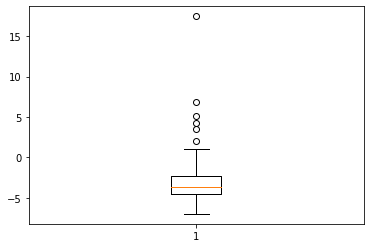

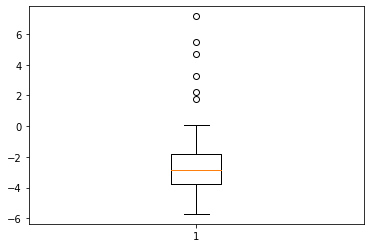

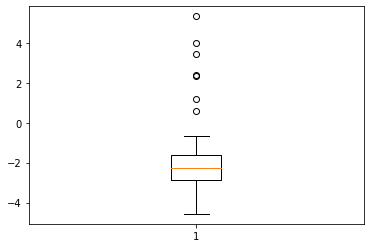

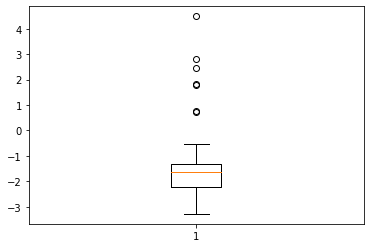

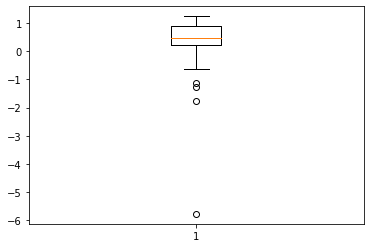

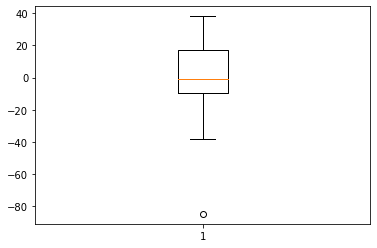

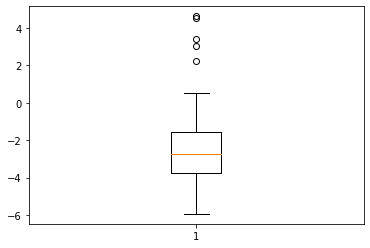

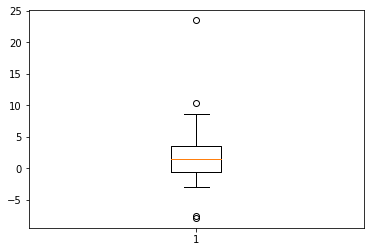

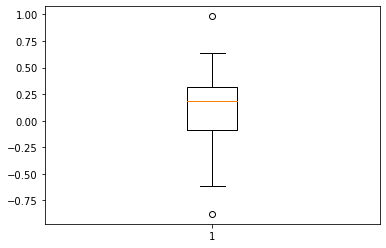

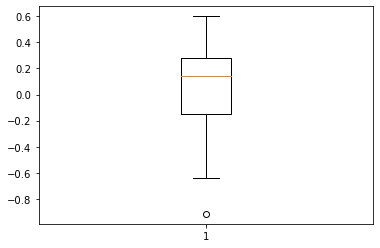

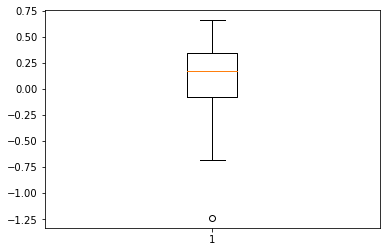

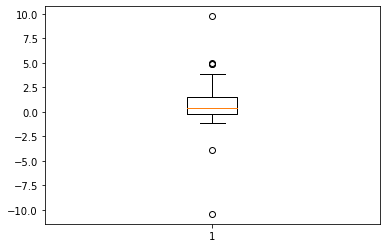

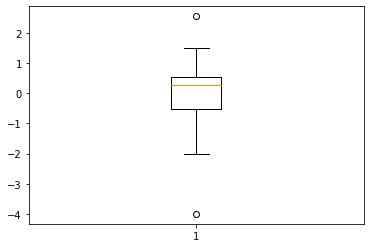

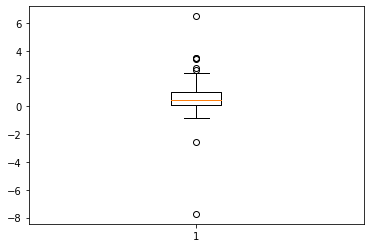

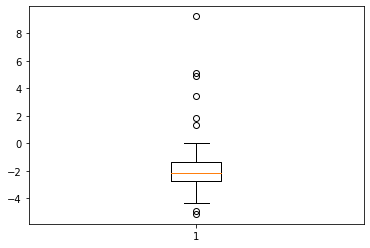

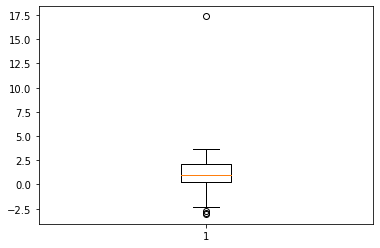

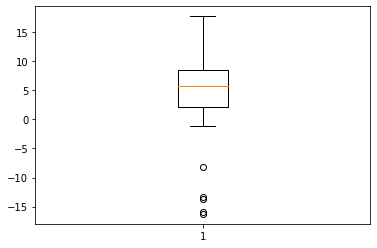

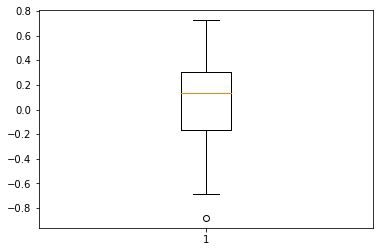

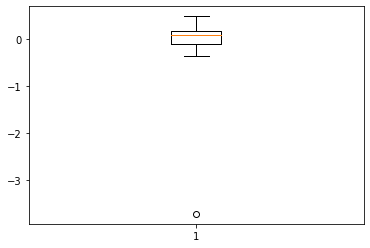

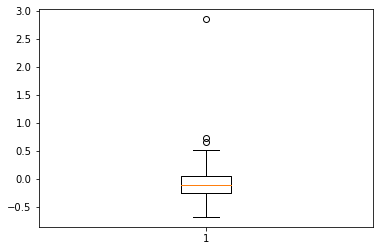

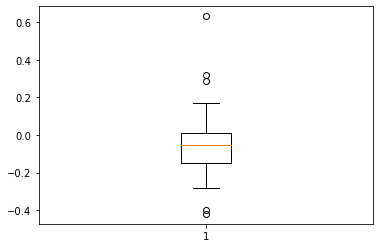

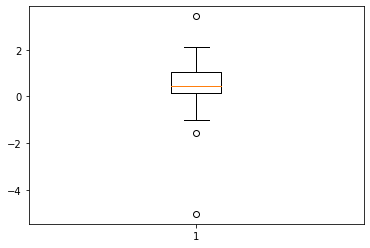

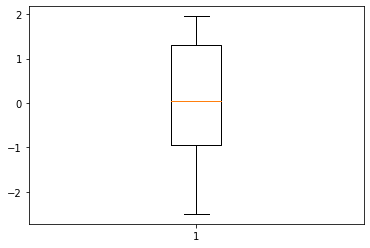

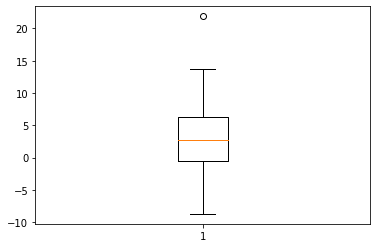

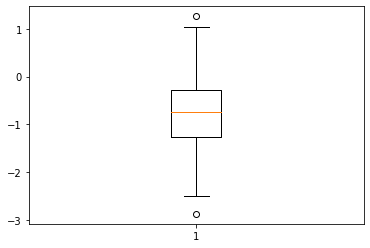

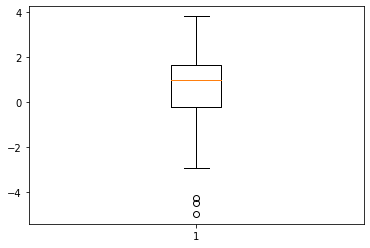

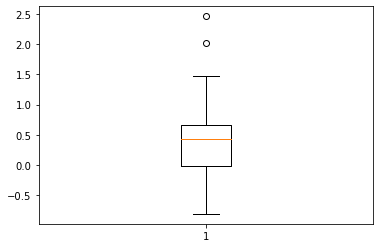

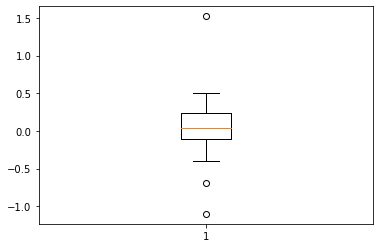

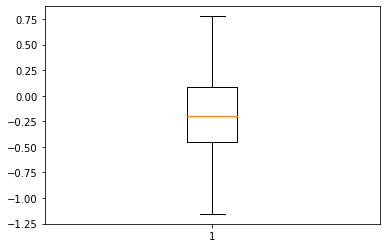

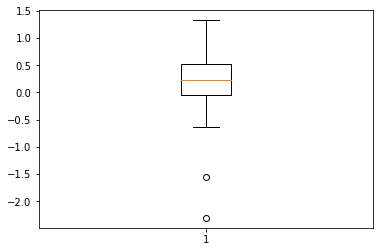

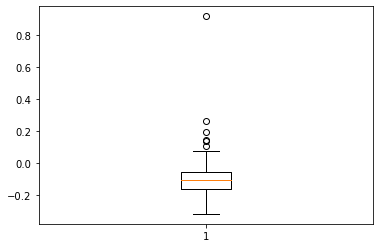

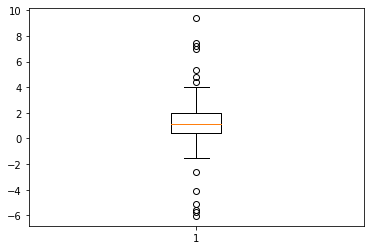

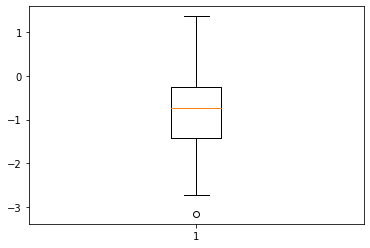

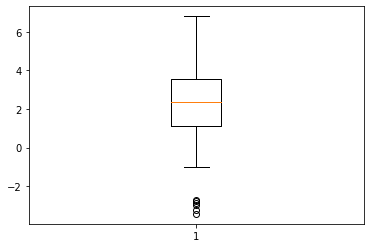

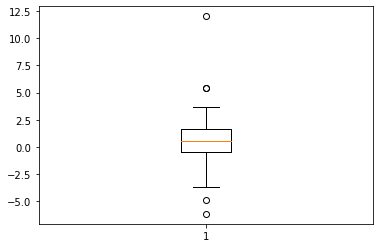

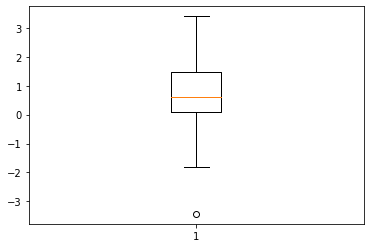

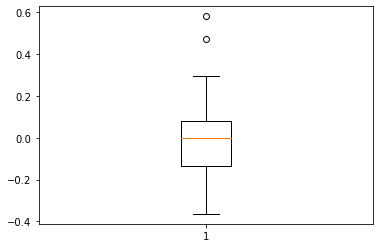

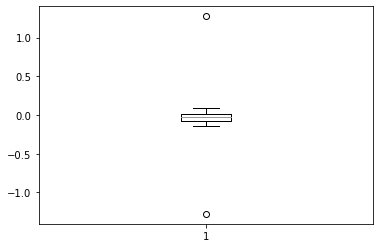

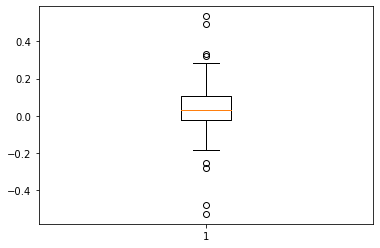

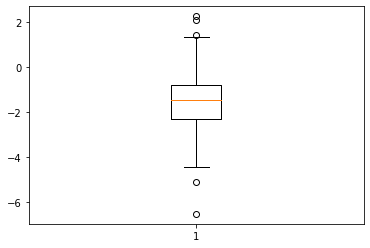

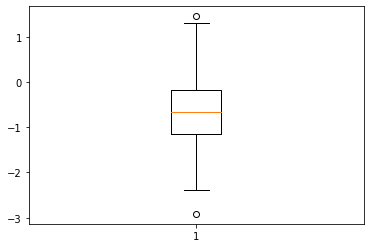

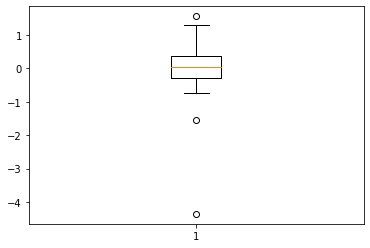

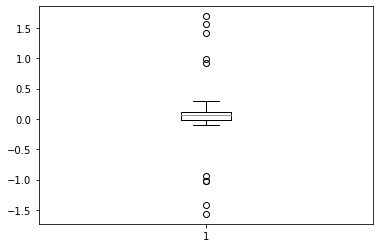

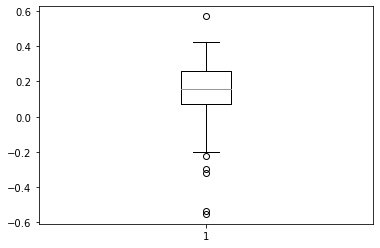

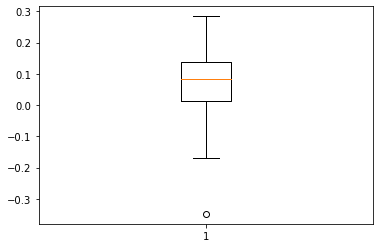

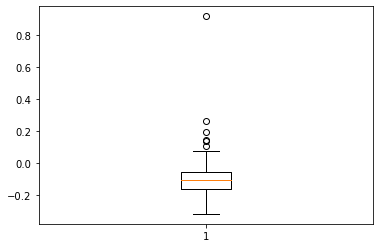

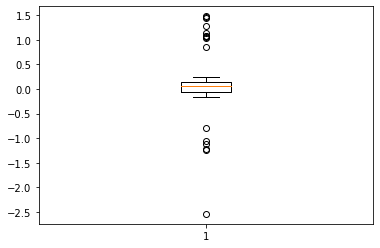

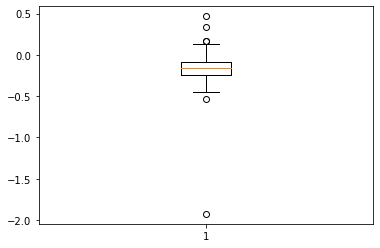

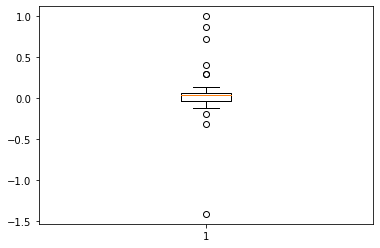

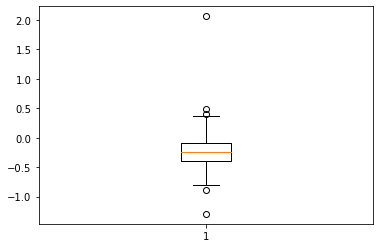

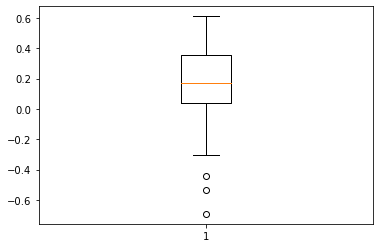

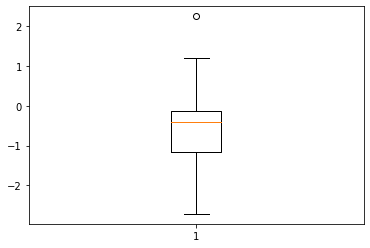

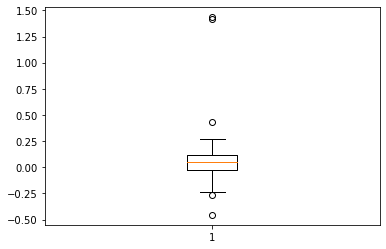

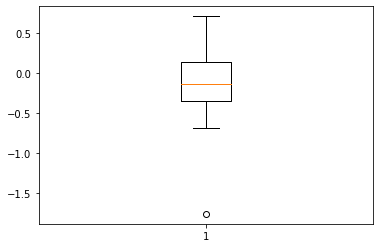

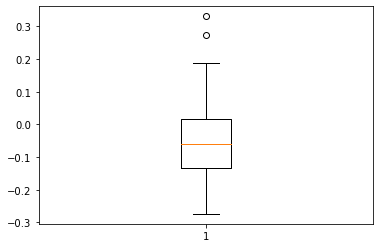

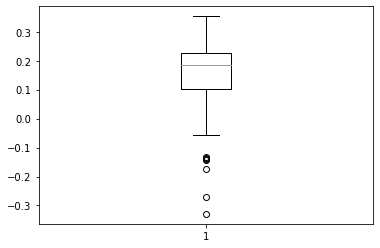

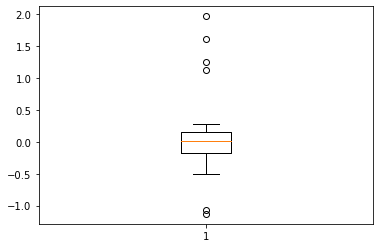

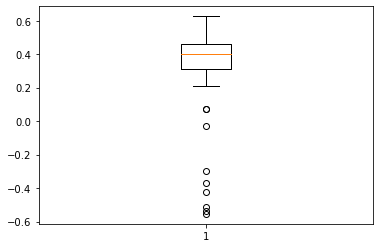

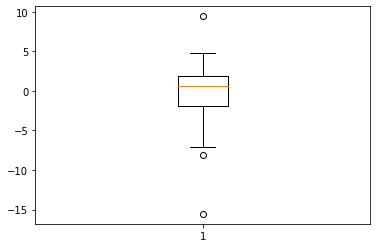

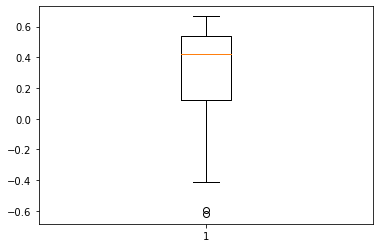

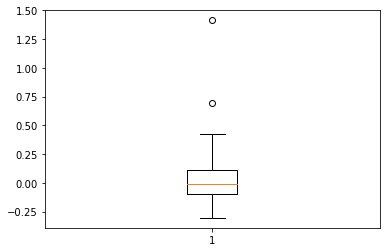

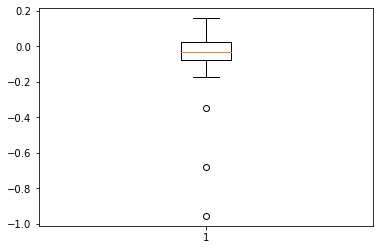

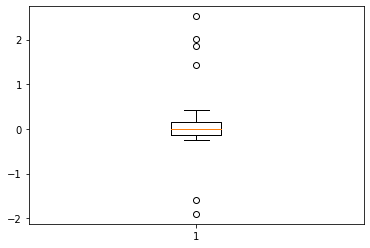

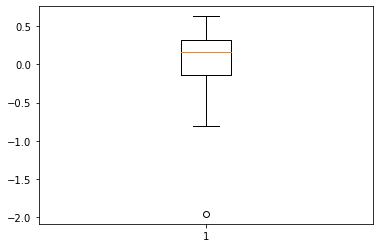

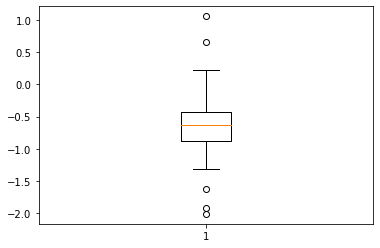

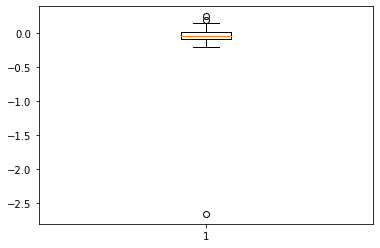

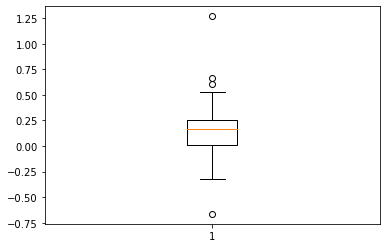

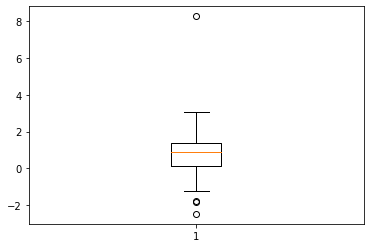

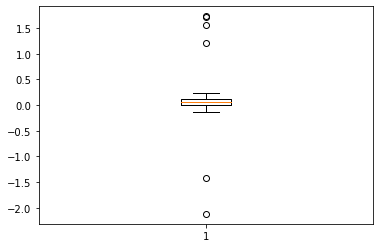

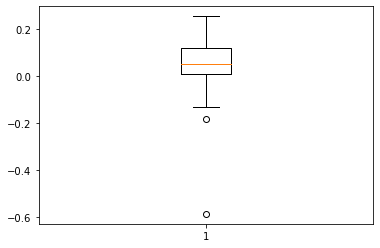

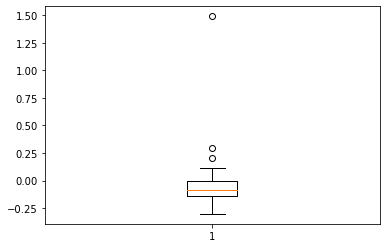

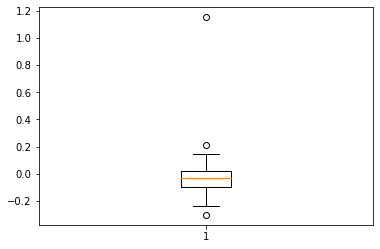

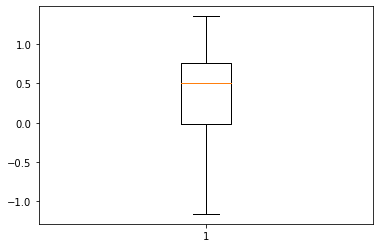

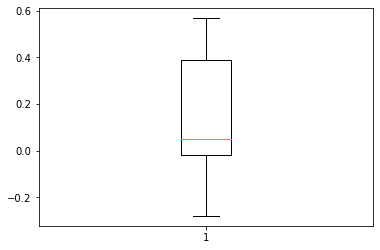

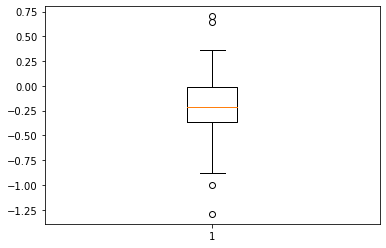

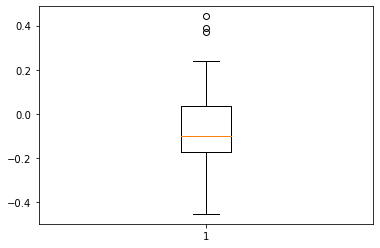

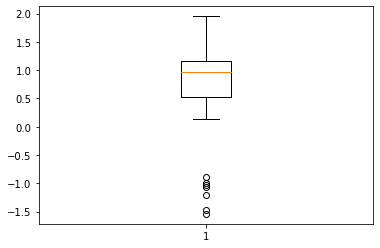

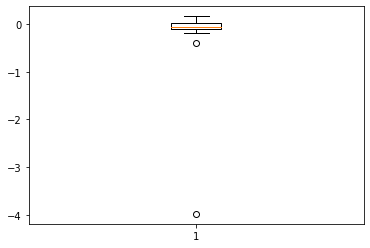

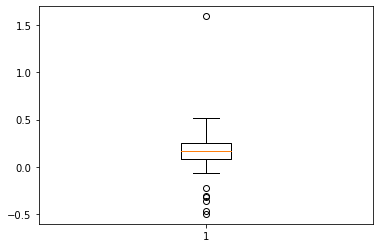

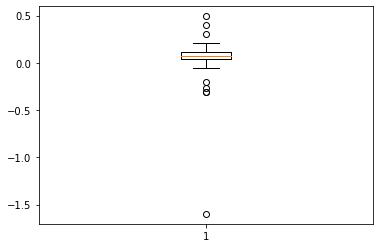

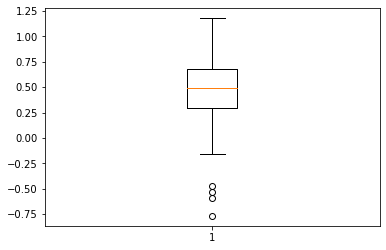

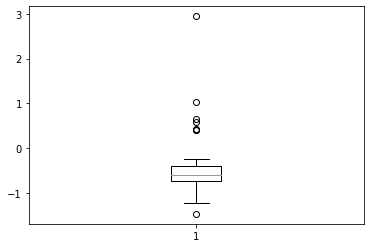

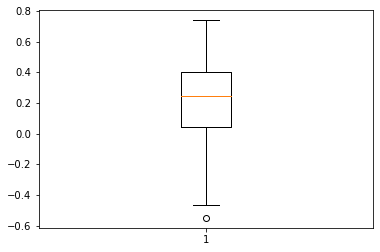

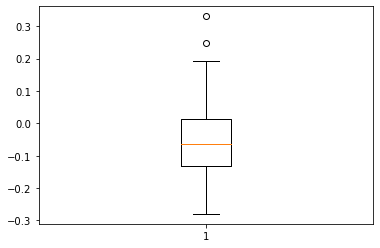

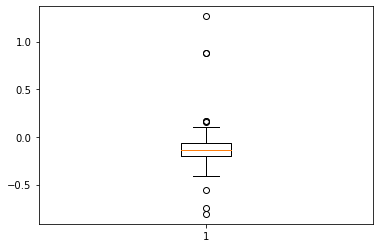

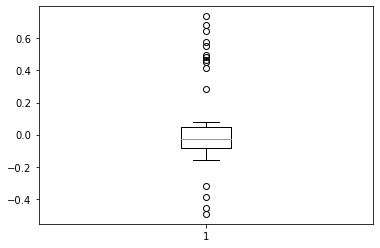

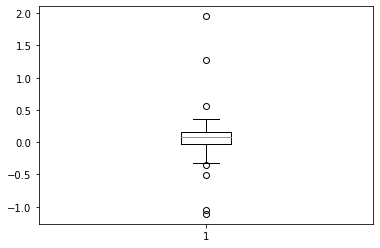

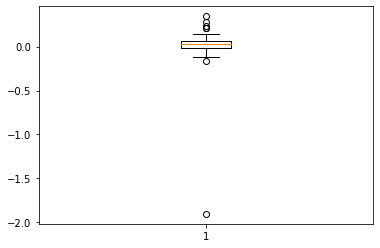

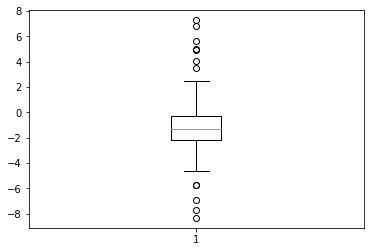

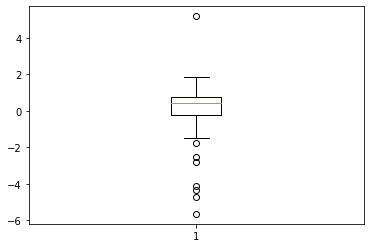

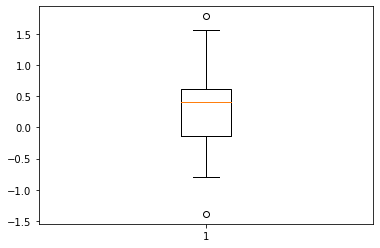

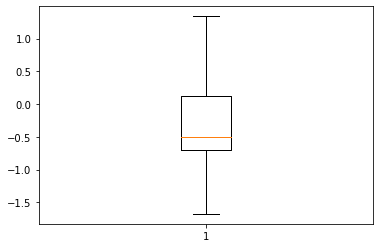

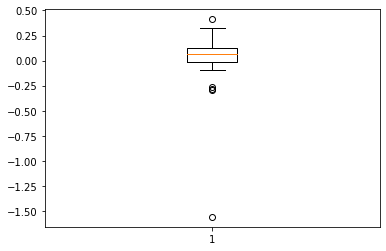

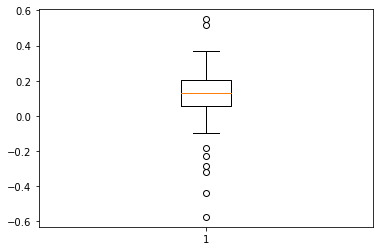

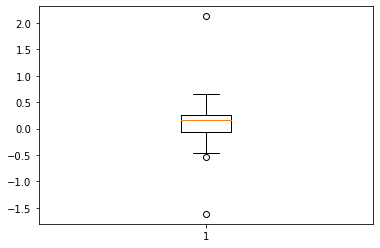

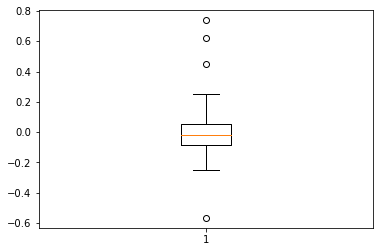

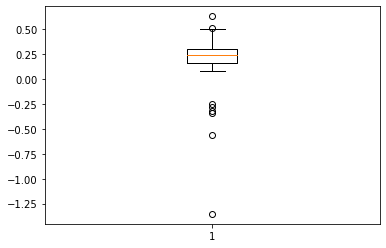

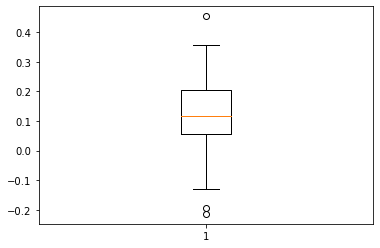

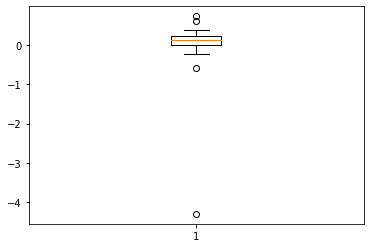

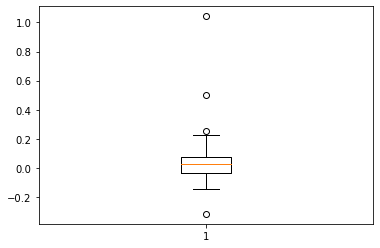

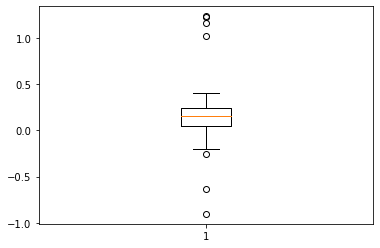

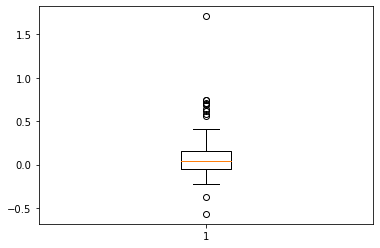

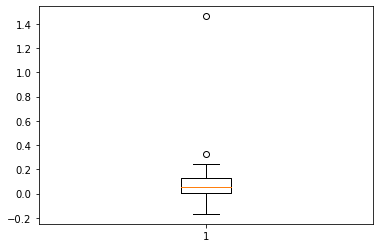

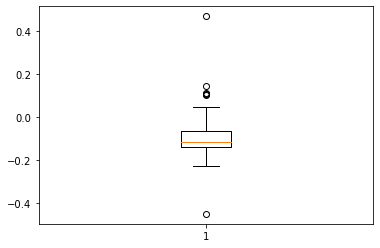

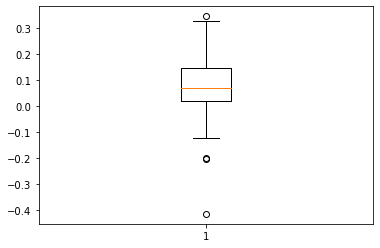

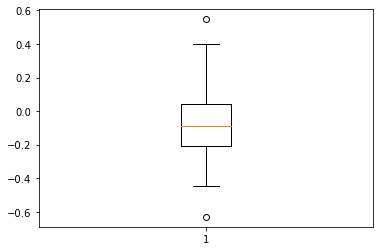

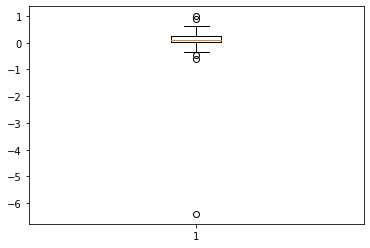

In [131]:
for i in range(204):
    plt.figure()
    plt.boxplot(coefs_df.T.loc[:,i])

In [116]:
coefs_df.set_axis(fea_name, axis=0).to_csv('Balanced weight feature coefficients.csv')

0.8128492484316544
0.7954939341421143
              precision    recall  f1-score   support

           0       0.96      0.79      0.86      1439
           1       0.44      0.84      0.58       292

    accuracy                           0.80      1731
   macro avg       0.70      0.81      0.72      1731
weighted avg       0.87      0.80      0.82      1731

0.39955242169815114
0.8128492484316544


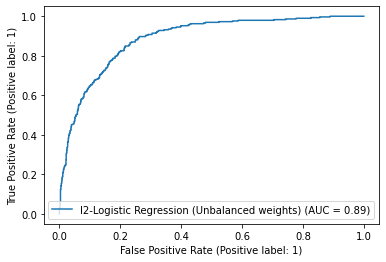

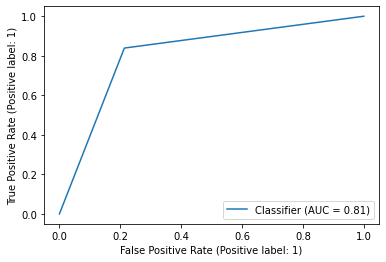

In [143]:
from sklearn import metrics
print(balanced_accuracy_score(y_test,y_pred_unbalanced))
print(metrics.accuracy_score(y_test,y_pred_unbalanced))
print(classification_report(y_test,y_pred_unbalanced))
print(metrics.average_precision_score(y_test, y_pred_unbalanced))

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_unbalanced)
print(metrics.auc(fpr, tpr))
ax = plt.gca()
RocCurveDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_pred_unbalanced)

In [140]:
np.mean(bal_accs)

0.7869890702166187

#### Unbalanced

In [27]:
print(np.mean(bal_accs))
print(np.mean(auc_scores))

0.6402431407741288
0.8575805013280444


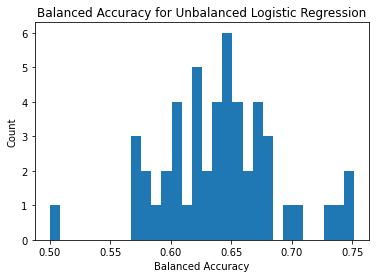

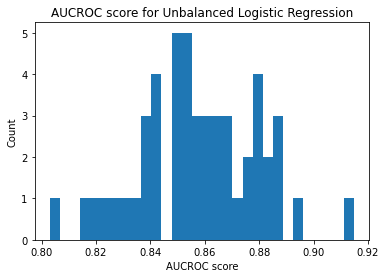

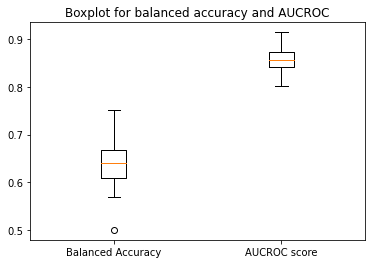

In [28]:
plt.hist(bal_accs, bins = 30)
plt.title('Balanced Accuracy for Unbalanced Logistic Regression')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Count')
plt.show()

plt.hist(auc_scores, bins = 30)
plt.title('AUCROC score for Unbalanced Logistic Regression')
plt.xlabel('AUCROC score')
plt.ylabel('Count')
plt.show()


plt.boxplot([bal_accs, auc_scores])
plt.title('Boxplot for balanced accuracy and AUCROC')
plt.xticks([1, 2], ["Balanced Accuracy","AUCROC score"])
plt.show()

#### Balanced

In [30]:
print(np.mean(bal_accs_w))
print(np.mean(auc_scores_w))

0.7885519609421122
0.858162810156919


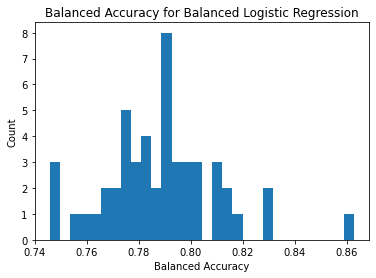

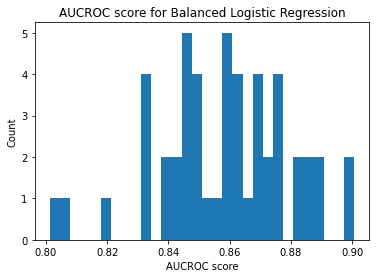

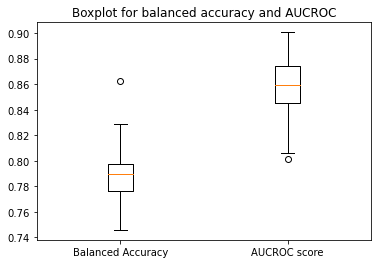

In [31]:
plt.hist(bal_accs_w, bins = 30)
plt.title('Balanced Accuracy for Balanced Logistic Regression')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Count')
plt.show()

plt.hist(auc_scores_w, bins = 30)
plt.title('AUCROC score for Balanced Logistic Regression')
plt.xlabel('AUCROC score')
plt.ylabel('Count')
plt.show()


plt.boxplot([bal_accs_w, auc_scores_w])
plt.title('Boxplot for balanced accuracy and AUCROC')
plt.xticks([1, 2], ["Balanced Accuracy","AUCROC score"])
plt.show()